**Identify a deafault client (CREDIT SCORING)**
This work has been made in cooperation with paul_dark
#### [GitHub](https://www.kaggle.com/pauldark)
#### [Kaggle](https://github.com/Paull-dark)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
from pandas import Series
import pandas as pd
import pandas_profiling
import numpy as np
from datetime import datetime, timedelta

# from dataprep.eda import plot, plot_correlation, create_report, plot_missing

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, plot_precision_recall_curve, plot_roc_curve

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
scaler = RobustScaler()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path = '/kaggle/input/sf-dst-scoring/'
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


# Функции

In [2]:
'''Функция, возвращающая порядковый день в году'''
def get_days_count(x):
    day = ((x.month-1) * 30)+x.day
    return day


'''Функция, возвращающая количество дней между датой заявки и сегодняшним числом'''
def get_days_beetwen(x):
    curr_date = datetime.today()
    count = (curr_date-x).days
    return count


'''Функция, возвращающая флаг подачи заявки в выходной день'''
def if_weekend(x):
    if x.weekday() in [5, 6]:
        return 1
    else:
        return 0


'''Функция, возвращающая месяц подачи заявки '''
def month(x):
    month = x.month
    return month

In [3]:
'''Возвращает бокслот'''
def get_boxplot(data, col1, col2, hue=None):
    '''Function is called to plot boxplots'''
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.boxplot(x=col1, y=col2, hue=hue, data=data, palette='mako')
    plt.xticks(rotation=45)
#     ax.set_title('Boxplot for ' + col1 + 'and' + col2,fontsize=14)
    ax.set_title(f'Boxplot for {col1} and {col2}', fontsize=14)
    plt.show()

In [4]:
'''Функция, определяющая флаг наличия поручителя среди людей с образованием 'PGR' и 'ACD'  '''
def has_no_garant(edu, grnt):
    if edu == 'PGR' or edu == 'ACD':
        grnt = 1
        return grnt
    else:
        grnt = 0
        return grnt

In [5]:
''' Функция, группирующая по возрастам'''
def age_to_cat(age):
    if age <= 28:
        cat_age = 'young'
        return cat_age
    if 28 < age <= 35:
        cat_age = 'semi-man'
        return cat_age
    if 35 < age <= 50:
        cat_age = 'midle'
        return cat_age
    if age > 50:
        cat_age = 'old'
        return cat_age

In [6]:
'''Класс выполняющий label и hot encodings'''
class Preprocessing:
    def __init__(self, data):
        self.data = data
#         self.column = column

    def label_encoder(self, column):
        le = LabelEncoder()
        self.data[column] = le.fit_transform(self.data[column])

    def hot_enc(self, column):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.data[[column]]))
        aux_df.columns = ohe.get_feature_names(['hot_encode'])
        self.data = self.data.drop(col, axis=1)
        self.data = pd.concat([self.data, aux_df], axis=1)
        return self.data

In [7]:
'''Функция, вызываемая для создания матрицы ошибок'''
def make_confusion_matrix(cf, group_names=['TN', 'FP', 'FN', 'TP'],
                          categories='auto',
                          sum_stats=True,
                          count=True,
                          cbar=True,
                          percent=True,
                          cmap='Blues'):
    
    # Код генерированя текста в каждом квадрате
    blanks = ['' for i in range(cf.size)]

    group_labels = ["{}\n".format(value) for value in group_names]

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(
            value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(
        group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # Метрики
    if sum_stats:
        # Accuracy  
        accuracy = np.trace(cf) / float(np.sum(cf))
        ball_accuracy = .5*(cf[1, 1] / sum(cf[1, :]) +
                            cf[0, 0] / sum(cf[0, :]))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # pr = how many real true
            precision = cf[1, 1] / sum(cf[:, 1])
            # How many positives from all positives
            recall = cf[1, 1] / sum(cf[1, :])
            # F1 score
            f1_score = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nBallancedAcc={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, ball_accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    plt.rcParams.get('figure.figsize')
    plt.figure(figsize=(5, 5))
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar,
                xticklabels=categories, yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)

In [8]:
'''Функция для возвращения таблицы с метриками'''
def get_scores(report_df, model, X_test, y_test, name):

    report = pd.DataFrame(columns={'ROC-AUG'}, data=[0])
    report['ROC-AUG'] = roc_auc_score(y_test,
                                      model.predict_proba(X_test)[:, 1])
    report['PR-AUC'] = precision_score(y_test, model.predict(X_test))
    report['F1'] = f1_score(y_test, model.predict(X_test))
    report['precision_0'] = precision_score(
        y_test, model.predict(X_test), pos_label=0)
    report['recall_0'] = recall_score(
        y_test, model.predict(X_test), pos_label=0)
    report['precision_1'] = precision_score(
        y_test, model.predict(X_test), pos_label=1)
    report['recall_1'] = recall_score(
        y_test, model.predict(X_test), pos_label=1)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [9]:
'''Функция рисует roc_auc кривую'''
def make_roc_auc(model, X, y):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    plot_precision_recall_curve(model, X, y, ax=ax1)
    plot_roc_curve(model, X_test, y_test, ax=ax2)
    plt.show()

In [10]:
'''Корреляционная матрица'''
def corr_matrix(data, det=True, pltx=10, plty=10):
    X = data.corr()
    if det:
        evals, evec = np.linalg.eig(X)
        ev_product = np.prod(evals)

        print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
        print(f'Determinat of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(X)}')

    plt.figure(figsize=(pltx, plty))
    sns.heatmap(X, vmin=0, vmax=.9, cmap='mako', annot=True, square=True)
    plt.show()

In [11]:
'''Функция энкодинга фичей'''
def pre_processing(column, data):
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])

# Загрузка данных

In [12]:
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
sub = pd.read_csv(path+'sample_submission.csv')

# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# sub = pd.read_csv('sample_submission.csv')

print(f'Размерность тренировочного датасета: {train.shape}')
print(f'Размерность тестового датасета: {test.shape}')

Размерность тренировочного датасета: (73799, 19)
Размерность тестового датасета: (36349, 18)


In [13]:
train[:4]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0


In [14]:
test[:4]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N


In [15]:
sub[:4]

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501


### Проверим, пересекаются ли данные в тренировочном и тестовом датасетах


In [16]:
set(test.client_id) & set(set(train.client_id))

set()

##### (Не пересекаются)

### Объединяем таблицы с добавлением параметра-указателя принадлежности к тестовой выборке

In [17]:
train['test'] = 0
test['test'] = 1
df = pd.concat([train, test], axis=0)

In [18]:
RANDOM_SEED = 42  # Задаем random state

client_id           0.000000
app_date            0.000000
education           0.415995
sex                 0.000000
age                 0.000000
car                 0.000000
car_type            0.000000
decline_app_cnt     0.000000
good_work           0.000000
score_bki           0.000000
bki_request_cnt     0.000000
region_rating       0.000000
home_address        0.000000
work_address        0.000000
income              0.000000
sna                 0.000000
first_time          0.000000
foreign_passport    0.000000
default             0.000000
test                0.000000
dtype: float64


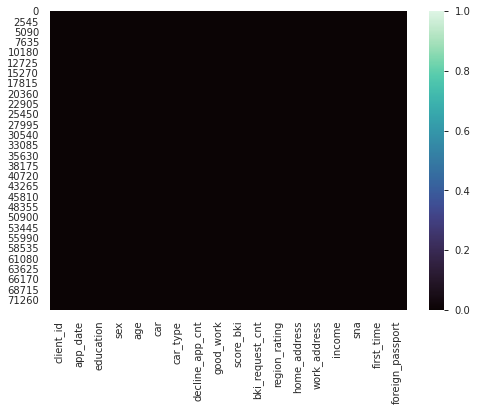

In [19]:
sns.heatmap(train.drop(['default', 'test'], axis=1).isnull(), cmap='mako')
print(train.isna().mean() * 100)  # ВЫражаем пропуски в процентах

Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту


####  Вывод: в тренировочной выборке   73799 записей, в тестовой 36349 записей. Имется небольшое количество пропусков в признаке education (0.43% суммарно), которые мы заполним. Данные в тренировочной и тестовой выборках не пересекаются 

In [20]:
train[:3]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,0


In [21]:
edu_name = train['education'].value_counts(
).index.to_list()  # Получаем список значений
edu_distr = train['education'].value_counts(
    normalize=True).values  # Получаем список вероятностей
missing = train['education'].isnull()  # Флаги с наличием пропусков
train.loc[missing, ['education']] = np.random.choice(
    edu_name, size=len(train[missing]), p=edu_distr)  # Подставляем значения из списка имен в соответствии в вероятностью встречи имени

<AxesSubplot:>

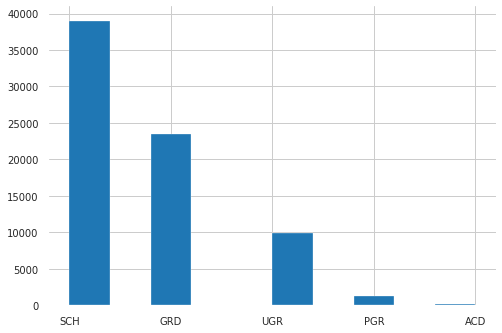

In [22]:
train['education'].hist()

## 1.Анализ данных

<function matplotlib.pyplot.show(close=None, block=None)>

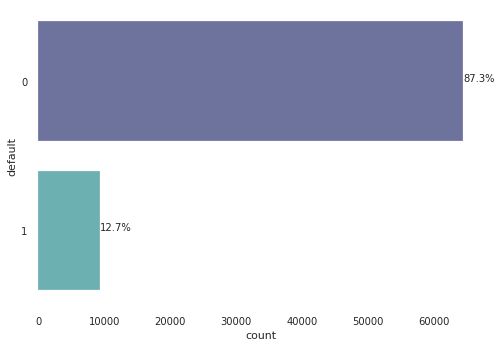

In [23]:
ax = sns.countplot(y='default', data=train, alpha=0.8, palette='mako')
total = train.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))
plt.show

## Имеется дисбаланс классов, попробуем его решить без применения методик по устранению дисбаланса и с ними


client_id        |73799      |int64 
app_date         |120        |object 
education        |5          |object 
sex              |2          |object 
age              |52         |int64 
car              |2          |object 
car_type         |2          |object 
decline_app_cnt  |21         |int64 
good_work        |2          |int64 
score_bki        |69096      |float64 
bki_request_cnt  |38         |int64 
region_rating    |7          |int64 
home_address     |3          |int64 
work_address     |3          |int64 
income           |966        |int64 
sna              |4          |int64 
first_time       |4          |int64 
foreign_passport |2          |object 
default          |2          |int64 
test             |1          |int64 


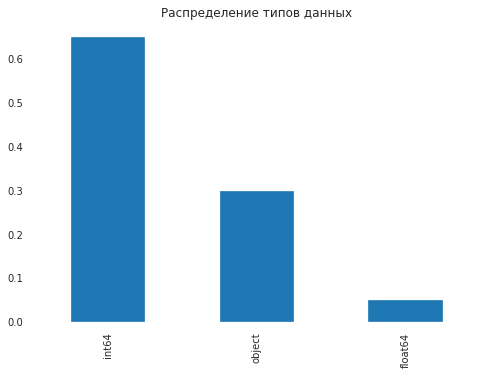

In [24]:
for i in train.columns:
    print('{0:<16} |{1:<10} |{2} '.format(
        i, train[i].nunique(), train[i].dtypes))
    train.dtypes.value_counts(normalize=True).plot(
        kind='bar', title='Распределение типов данных')

### Исходя из кол-ва возможных значений и описания признаков, делим признаки на числовые, категориальные и бинарные

In [25]:
bin_ = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
num_ = ['age',  'income', 'score_bki']
cat_ = ['decline_app_cnt', 'bki_request_cnt', 'education',
        'work_address', 'home_address', 'sna', 'region_rating', 'first_time']

## Не смотря на то, что признаки  'decline_app_cnt' и 'bki_request_cnt' похожи на числовые с выбросами, мы не будем избавляться от выбросов, но отметим эти признаки как категориальные, т.к. количество запросов в БКИ и количество отказов могут прояснить ситуацию с благополучностью и надежностью потенциального клиента.

### Посмотрим на них поближе



Распределение значений 'decline_app_cnt'

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64






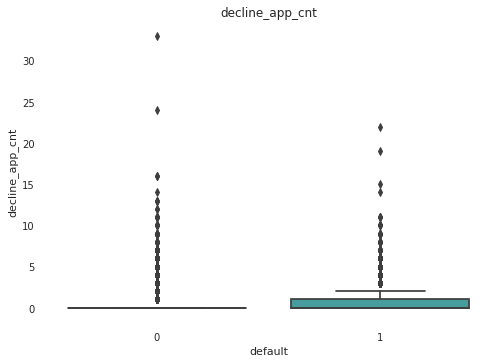



Распределение значений 'bki_request_cnt'

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64






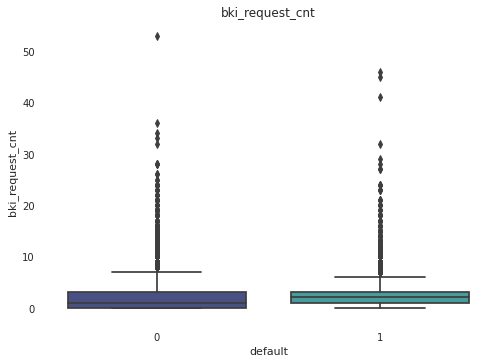

In [26]:
for i in ['decline_app_cnt', 'bki_request_cnt']:
    plt.figure()
    sns.boxplot(x=train['default'], y=train[i], palette='mako')
    print('\n\nРаспределение значений \'{0}\'\n\n{1}\n\n\n\n'.format(
        i, train["decline_app_cnt"].value_counts()))
    plt.title(i)
    plt.show()

# Числовые признаки

### Преобразуем признак с датой и добавим дополнительные фичи 

In [27]:
train['app_date'] = pd.to_datetime(train['app_date'])  # Преобразуем в datetime
train['weekend'] = train['app_date'].apply(
    lambda x: (if_weekend(x)))  # Флаг выходного дня
train['days_numb'] = train['app_date'].apply(
    lambda x: (get_days_count(x)))  # Порядковый номер дня в году
# Кол- во дней между подачей заявки и сегодняшним числом
train['days_beetwen'] = train['app_date'].apply(
    lambda x: (get_days_beetwen(x)))
train['month'] = train['app_date'].apply(lambda x: (month(x)))

In [28]:
train = train.drop('app_date', axis=1)  # Удалим столбец app_date

In [29]:
bin_ = bin_ + ['weekend']
num_ = num_ + ['days_numb', 'days_beetwen']
cat_ = cat_ + ['month']

In [30]:
train

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,income,sna,first_time,foreign_passport,default,test,weekend,days_numb,days_beetwen,month
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,...,18000,4,1,N,0,0,1,31,2634,2
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,...,19000,4,1,N,0,0,0,72,2595,3
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,...,30000,1,4,Y,0,0,1,31,2634,2
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,...,10000,1,3,N,0,0,0,23,2643,1
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,...,30000,1,4,Y,0,0,0,108,2558,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,GRD,F,45,N,N,0,0,-1.792064,3,...,17000,4,4,N,0,0,0,64,2603,3
73795,76821,SCH,M,41,Y,Y,0,0,-2.058029,1,...,70000,1,4,N,0,0,0,84,2583,3
73796,103695,SCH,M,31,N,N,0,0,-1.512635,4,...,45000,2,2,N,0,0,0,112,2554,4
73797,861,SCH,F,29,N,N,0,1,-1.479334,3,...,13000,2,3,N,1,0,1,4,2662,1


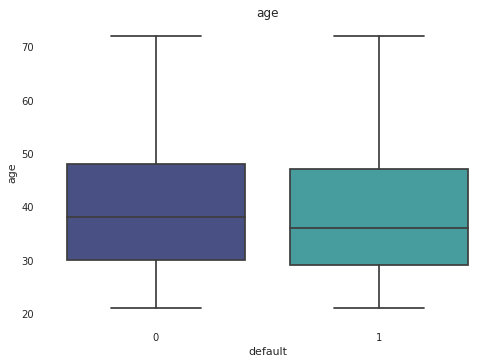

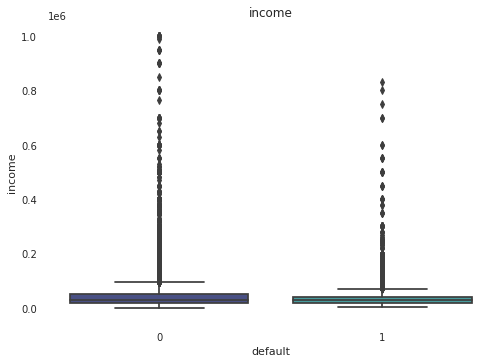

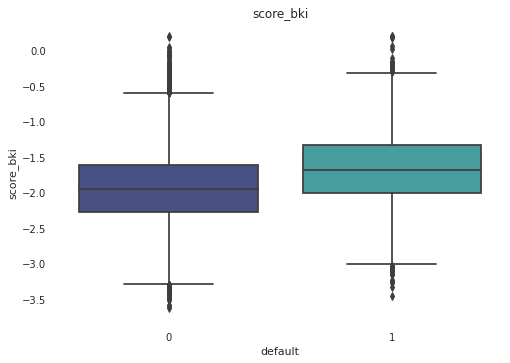

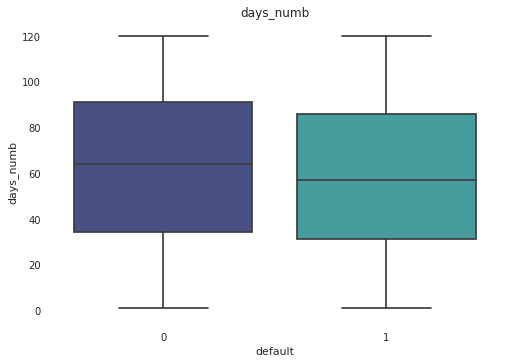

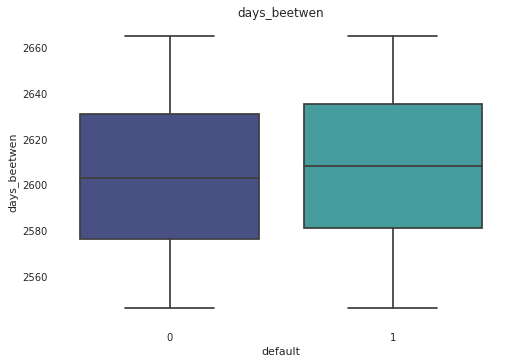

In [31]:
for i in num_:
    plt.figure()
    sns.boxplot(x=train['default'], y=train[i], palette='mako')
    plt.title(i)
    plt.show()

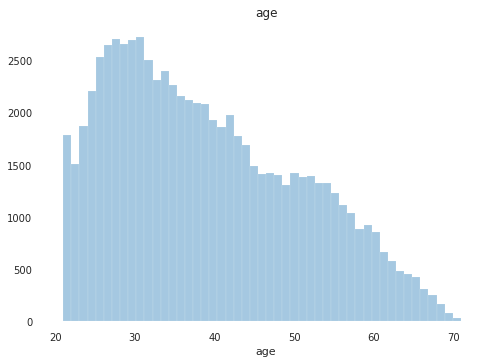

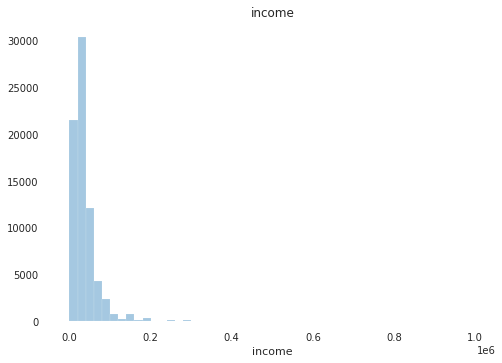

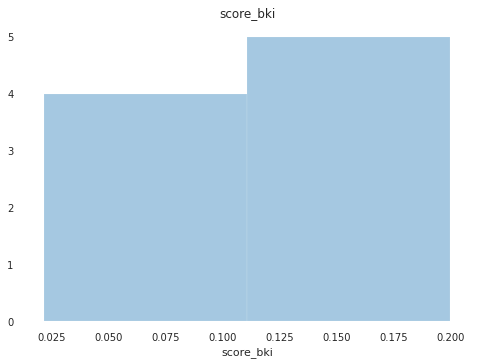

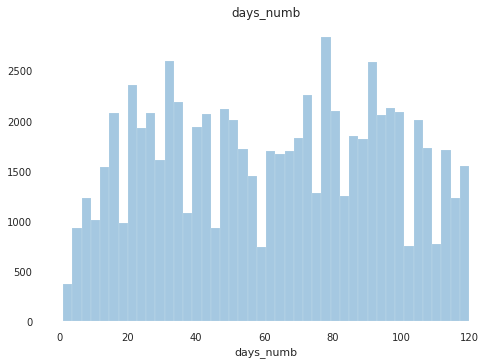

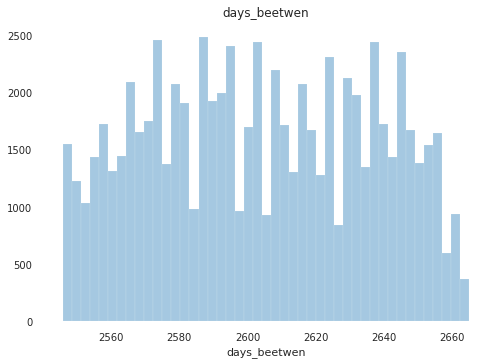

In [32]:
# Построим распределенеие числовых признаков
for i in num_:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

In [33]:
'''пока не используется'''
# def get_blowout(x):
#     blowouts = dict.fromkeys(['age', 'income', 'score_bki', 'days_numb', 'days_beetwen'])
#     for i in num_:
#         Q1 = np.percentile(df[i],25)
#         Q3 = np.percentile(df[i],75)
#         q_range = Q3 - Q1
#         right = (df[i][df[i] > (Q3+1.5*q_range)]).values
#         left = (df[i][df[i] < (Q1-1.5*q_range)]).values
#         blowouts.update({i:(set(left),set(right))})
#     return display(blowouts)

'пока не используется'

In [34]:
train[['sex', 'age']].value_counts()

sex  age
M    28     1424
     31     1394
     27     1387
     29     1375
     30     1374
            ... 
     69       18
     70        5
F    72        2
M    71        2
F    71        1
Length: 103, dtype: int64

In [35]:
train[num_]

,age,income,score_bki,days_numb,days_beetwen
0,62,18000,-2.008753,31,2634
1,59,19000,-1.532276,72,2595
2,25,30000,-1.408142,31,2634
3,53,10000,-2.057471,23,2643
4,48,30000,-1.244723,108,2558
...,...,...,...,...,...
73794,45,17000,-1.792064,64,2603
73795,41,70000,-2.058029,84,2583
73796,31,45000,-1.512635,112,2554
73797,29,13000,-1.479334,4,2662


### Видим, что на графиках имеется выраженный хвост вправо. Прологарифмируем.

In [36]:
'''ЛОГАРИФМИРОВАНИЕ'''

train['score_bki'] = train['score_bki'] + \
    99  # Прибавили число, чтобы избавитья от inf значений
for col in num_:
    train[col] = np.log(train[col])

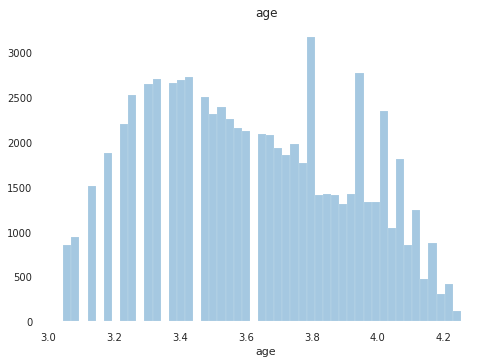

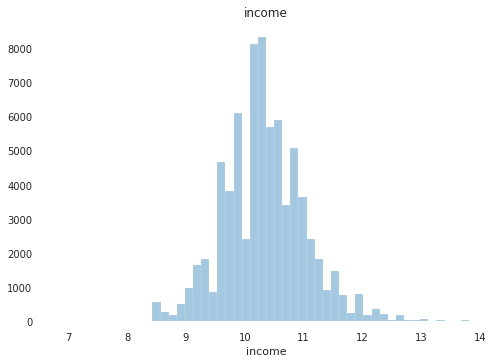

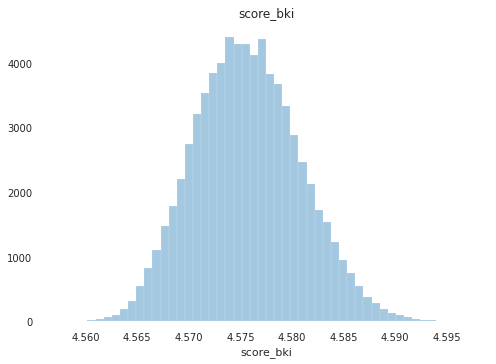

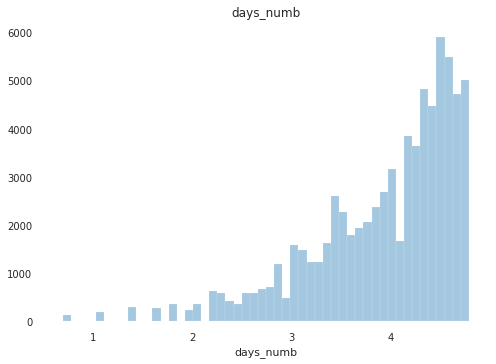

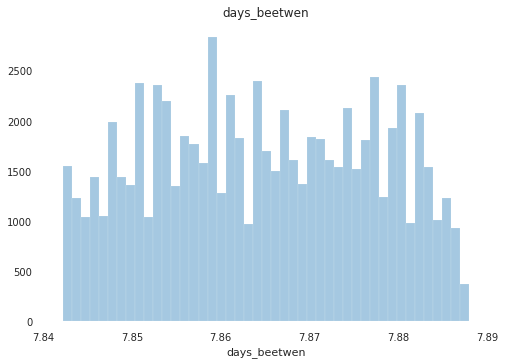

In [37]:
for i in num_:
    plt.figure()
    sns.distplot(train[i][
        train[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

Rank of Matrix: 5
Determinat of matrix: 0.1367
Shape of matrix: (5, 5)


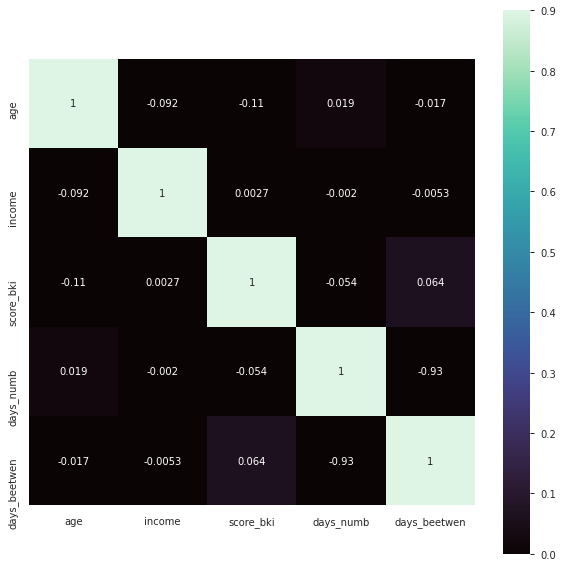

In [38]:
corr_matrix(train[num_])

<AxesSubplot:>

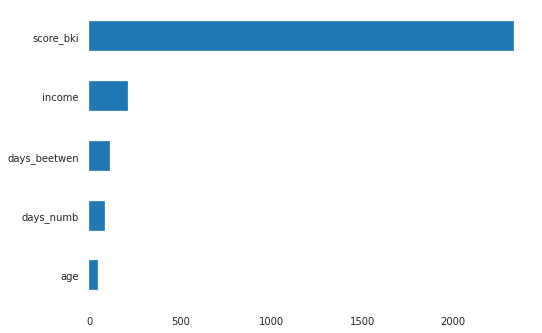

In [39]:
imp_num = Series(f_classif(train[num_], train['default'])[0], index=num_)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

### Большую значимость имеет признак score_bki. Признак days_numb и days_beetwen сильно обратно скоррелированы, удалим days_numb т.к его значимость ниже и график расспределения имеет хвост влево 

In [40]:
train = train.drop('days_numb', axis=1)
num_.remove('days_numb')

#  Бинарные признаки

### Строим графики бинарных признаков от значения 'default' 

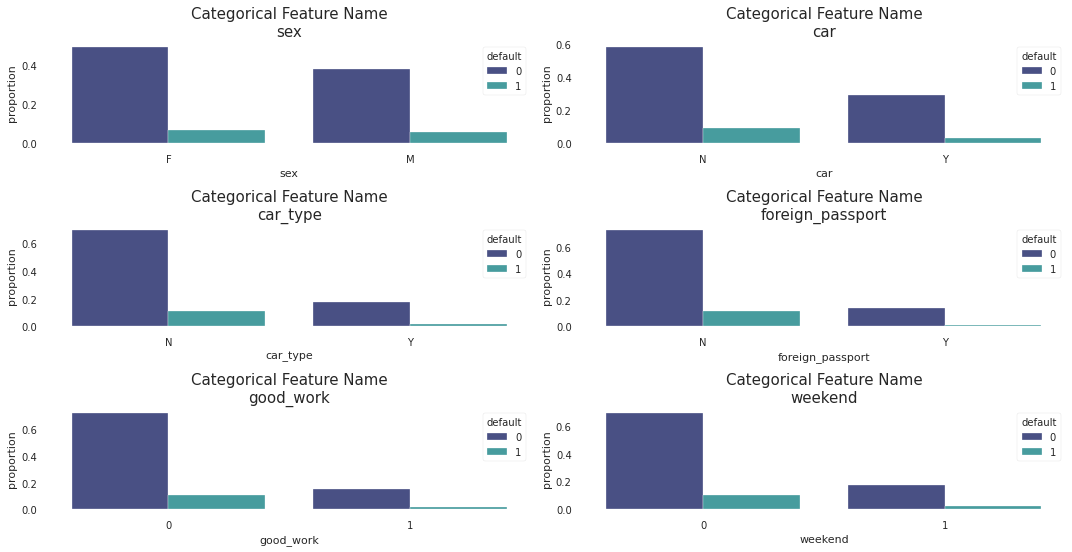

In [41]:
plt.figure(figsize=[15, 20])
i = 1

y, hue = 'proportion', 'default'

for k in bin_:
    plt.subplot(8, 2, i)
    sns.barplot(x=k, y='proportion', hue='default',  data=train[[
                k, 'default']].value_counts(normalize=True).rename('proportion').reset_index(), palette='mako')
    plt.title('Categorical Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

Глядя на барплоты, мы можем отметить, что женщины-заемщики, как правило, несут дефолт несколько чаще, чем мужчины.

Заемщики, у которых есть машина, можно считать более надежными. Заемщики, у которых нет машины, как правило, не погашают кредит в два раза чаще, чем те, у кого есть машина.

Те заемщики, у которых есть отечественный автомобиль или нет, склонны к дефолту чаще, чем те, у кого есть иномарка. Однако, если мы хотим видеть распределение более четким, нам нужно создать новую категорию в этом столбце: есть отечественная машина, есть иномарка, нет машины.

Люди, у которых хорошая работа и загранпаспорт, чаще возвращают ссуды, чем те, у кого плохая работа.

Давайте проверим, насколько наши особенности статистически значимы?

Для этого давайте закодируем его в двоичные объекты.

In [42]:
encoder = Preprocessing(train)
for col in bin_:
    encoder.label_encoder(col)

train.sample(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,test,weekend,days_beetwen,month
32404,11292,SCH,0,3.218876,0,0,1,0,4.574941,0,...,2,9.104980,2,2,0,0,0,1,7.881560,1
23129,23544,SCH,1,3.761200,0,0,0,0,4.570093,1,...,2,8.922658,1,3,1,0,0,0,7.877018,1
20598,91049,GRD,1,3.258097,0,0,1,1,4.569974,1,...,3,11.156251,2,2,0,0,0,0,7.851272,4


<AxesSubplot:>

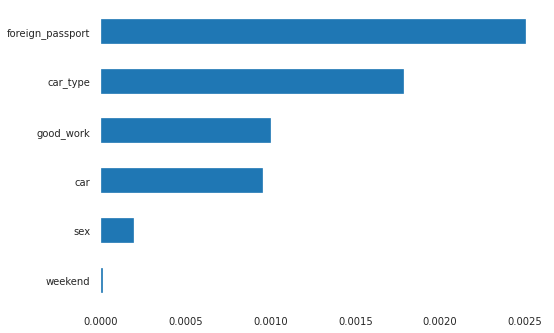

In [43]:
imp_bin = Series(mutual_info_classif(train[bin_], train['default'],
                                     discrete_features=True), index=bin_)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

#### Наиболее важными являются признаки foreign_passport и car_type . Добавленный нами ранее признак флага выходного дня показывает минимальные показатели. Удалим его

In [44]:
train = train.drop('weekend', axis=1)
bin_.remove('weekend')

Rank of Matrix: 5
Determinat of matrix: 0.4583
Shape of matrix: (5, 5)


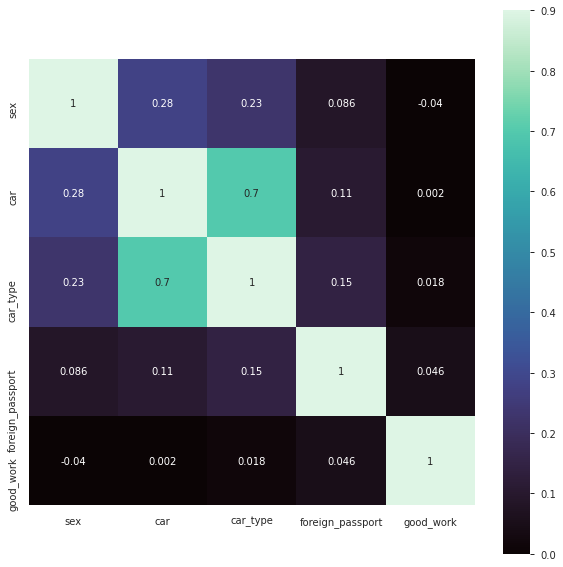

In [45]:
corr_matrix(train[bin_])

У нас сильная корреляция между car и car_type. Это можно объяснить тем, что в столбце car указано наличие автомобиля, а в столбце car_type - наличие иномарки, однако отсутствие автомобиля или то, является ли автомобиль отечественным, в car_type не указывается. В разделе проектирования функций мы объединим информацию из этих столбцов в один. Это позволяет уменьшить матрицу характеристик без потери информации.

Кроме того, автомобиль немного коррелирует с полом.

# Категориальные признаки

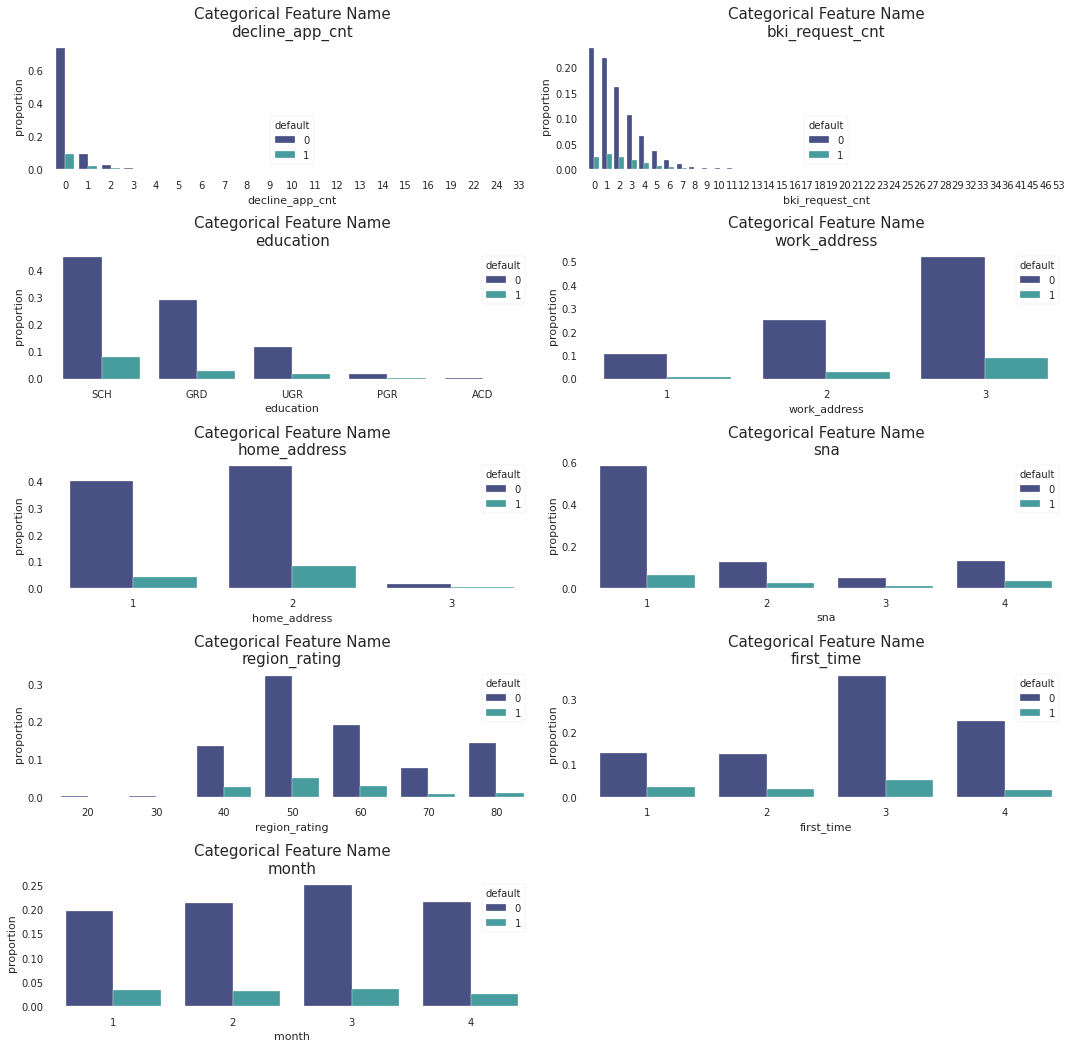

In [46]:
plt.figure(figsize=[15, 20])
i = 1

y, hue = 'proportion', 'default'

for k in cat_:
    plt.subplot(7, 2, i)
    sns.barplot(x=k, y='proportion', hue='default',  data=train[[
                k, 'default']].value_counts(normalize=True).rename('proportion').reset_index(), palette='mako')
    plt.title('Categorical Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

### Мы видим, что признаки decline_app_cnt и bki_request_cnt имеют очень большой разброс значений. На этапе создания новых признаков мы его уменьшим сгруппировав

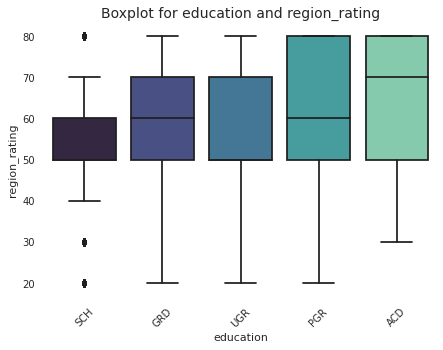

In [47]:
get_boxplot(train, 'education', 'region_rating')

Люди с высоким уровнем образования предпочитают жить в регионе с более высоким уровнем образования.

Хорошо, а теперь давайте посмотрим, как распределяются обанкротившиеся заемщики по region_rating.

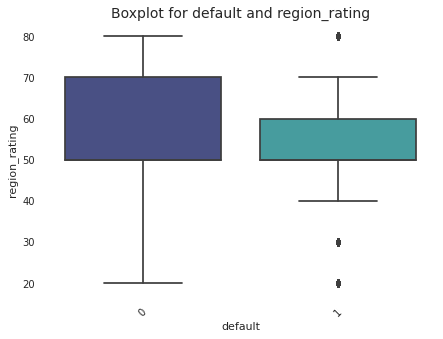

In [48]:
get_boxplot(train, 'default', 'region_rating')

Мы можем видеть, что клиенты по умолчанию живут в регионах среднего уровня. Чем выше рейтинг города, тем меньше вероятность дефолта. Это должно быть хорошее представление для модели.

Интересно, можем ли мы наблюдать какие-то связи между уровнем образования и связью заемщиков с другими клиентами банка? Посмотрим на это.

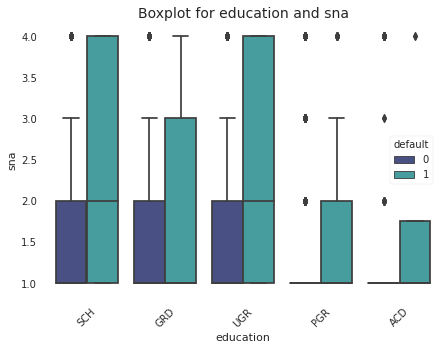

In [49]:
get_boxplot(train, 'education', 'sna', hue='default')

Связи с клиентами банка имеют люди, в основном с низким уровнем образования. Возможно это можно объяснить тем, что люди с низким образованием работают в больших коллективах (заводы, фабрики) и обмен информации лучше или людям с высоким образованием не нужны поручители. Дефолтных клиентов также больше именно в этих категориях.

In [50]:
train['has_no_guarantor'] = 0
train['has_no_guarantor'] = train[['education', 'has_no_guarantor']].apply(
    lambda x: has_no_garant(*x), axis=1)

In [51]:
bin_ = bin_ + ['has_no_guarantor']

In [52]:
for col in cat_:
    pre_processing(col, train)

<AxesSubplot:>

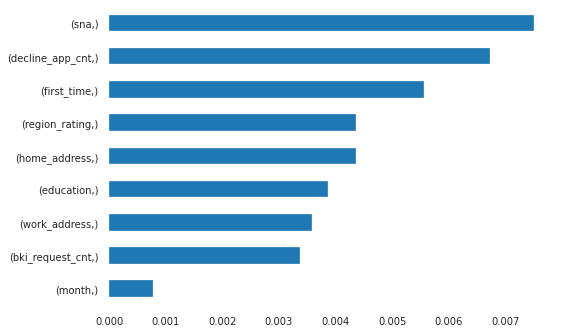

In [53]:
imp_cat = pd.Series(mutual_info_classif(train[cat_], train['default'],
                                        discrete_features=True), index=[cat_])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Rank of Matrix: 9
Determinat of matrix: 0.2781
Shape of matrix: (9, 9)


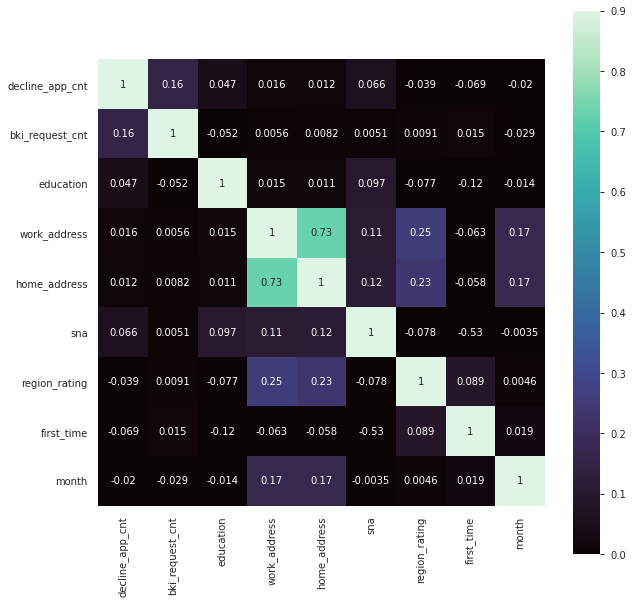

In [54]:
corr_matrix(train[cat_])

У нас довольно сильная корреляция между sna и first_time. Кроме того, эти два столбца имеют наибольшее значение для целевой переменной. Можно предположить, что эти две особенности можно объяснить следующим образом: этот человек давно является клиентом банка и, как следствие, приобрел связи с другими клиентами (возможно, поручителями). Признак меяца имеет статистическое значение. Как-то месяц соотносится с work_address

Домашний и рабочий адреса также коррелировали. Нам нужно подумать, что мы можем сделать с этими признаками

### Посмотрим полную матрицу корреляции

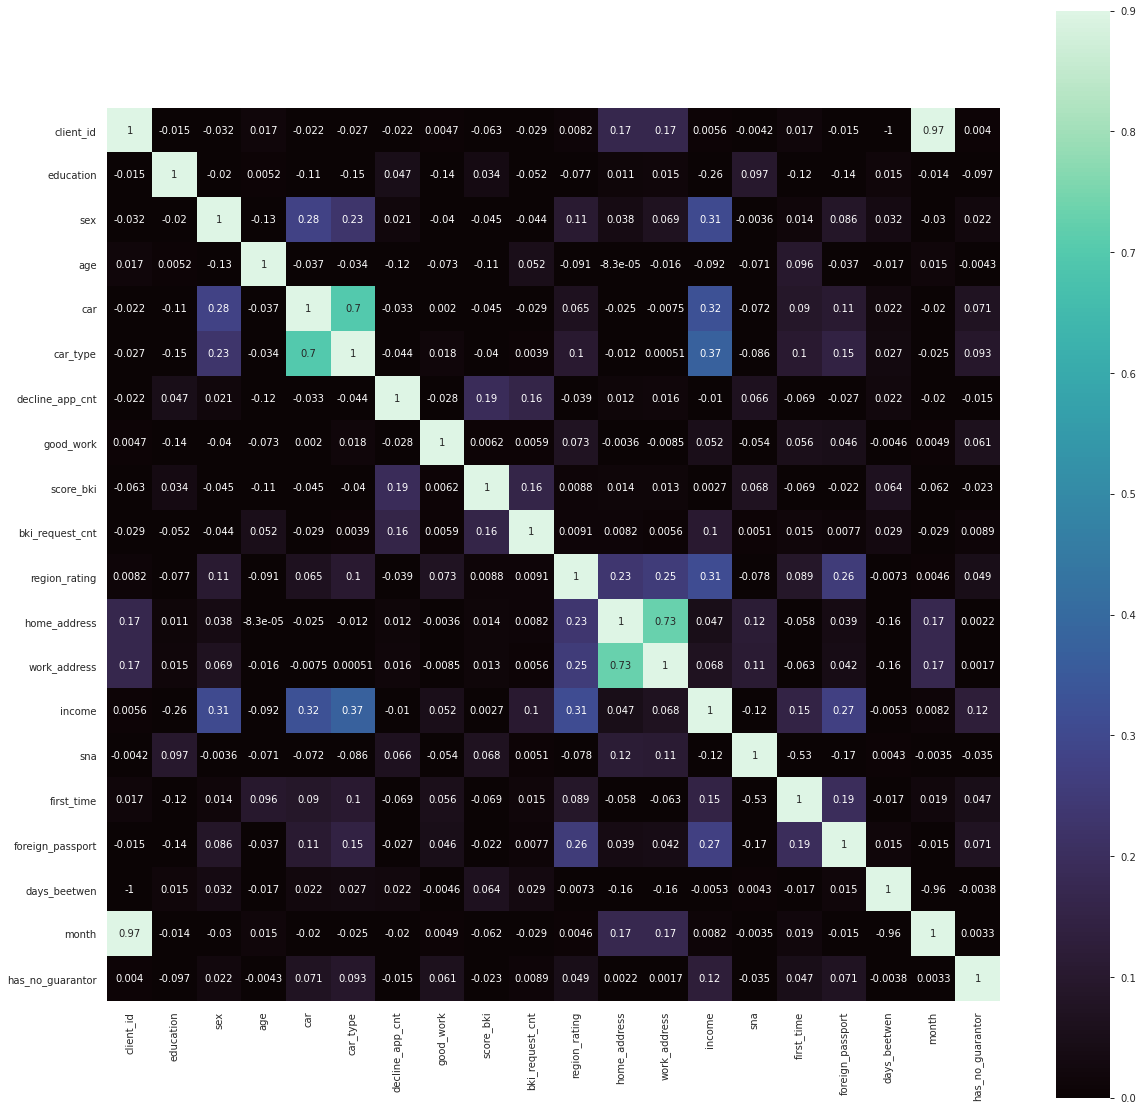

In [55]:
corr_matrix(train.drop(['default', 'test'], axis=1),
            det=False, pltx=20, plty=20)

Мы видим полную корреляцию признака client_id и month (порядковый номер дня в году). Это указывает на определенную систему присвоения номера клиента. Скорее всего, эти знаки дадут нам что-нибудь полезное.

car_type коррелирует с доходом. Это можно объяснить предположением, что если у заемщика больше доходов, то у него лучше машина, и наоборот.

sna имеет довольно сильную корреляцию с foreign_passport

> ### Выводы

**Бинарные:**

Автомобиль и car_type сильно коррелированы.

В столбце car указано наличие автомобиля, а в столбце car_type - наличие иномарки. Объедините их дальше

Количество дефолтных заемщиков мужского и женского пола практически одинаково. Однако женщины чаще ссужают деньги.

**Категориальные:**

Люди с низким уровнем образования не возвращают кредиты чаще, чем люди с высоким уровнем образования.

Больше отношений заемщика с другими клиентами - больше просроченных платежей. Признак **'has no guarantors'**, может быть добавлен людям с высоким уровнем образования.

Люди с высоким уровнем образования предпочитают жить в регионе с более высоким уровнем образования.

Чем выше рейтинг города, тем меньше вероятность дефолта

Корреляция между **'sna'** и **'first_time'**, **'home_address'** и **'work_address'**.

**Числовые:**

**'score_bki'** имеет распределение близкое к нормальному. Это уже масштабируется ЗППП (скорее всего)

У данных есть выбросы. Тем не менее, лучше некоторые функции преобразовать в категориальный тип.

Нет сильной корреляции между функциями

Car_type коррелирует с доходом

Sna имеет довольно сильную корреляцию с foreign_passport

**Статистически наиболее значимые:**

'foreign_passport'

'car_type'

'sna'

'first_time'

'region_rating'

'Score_bki'

'decline_app_cnt'

Поскольку у нас нет очевидной корреляции и связи между признаками, лучше использовать модели descicion tree или logistic regressions.


# Создание признаков

In [56]:
df = df.drop('client_id', axis=1)

In [57]:
edu_name = df['education'].value_counts(
).index.to_list()  # Получаем список значений
edu_distr = df['education'].value_counts(
    normalize=True).values  # Получаем список вероятностей
missing = df['education'].isnull()  # Флаги с наличием пропусков
df.loc[missing, ['education']] = np.random.choice(
    edu_name, size=len(df[missing]), p=edu_distr)  # Подставляем значения из списка имен в соответствии в вероятностью встречи имени

# car & car_type

In [58]:
encoder = Preprocessing(df)
for i in list(['car', 'car_type']):
    encoder.label_encoder(i)

In [59]:
df['car_comb'] = df['car'] + df['car_type']
df = df.drop(['car', 'car_type'], axis=1)

In [60]:
df

,app_date,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test,car_comb
0,01FEB2014,SCH,M,62,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,0,2
1,12MAR2014,SCH,F,59,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,0,0
2,01FEB2014,SCH,M,25,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,0,1
3,23JAN2014,SCH,F,53,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,0,0
4,18APR2014,GRD,M,48,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,31MAR2014,SCH,F,37,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,1,0
36345,25APR2014,GRD,F,64,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,1,2
36346,30MAR2014,GRD,M,31,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,1,0
36347,07JAN2014,UGR,F,27,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,1,0


# age

In [61]:
df['age_cat'] = 0
df['age_cat'] = df['age'].apply(lambda x: age_to_cat(x))

In [62]:
# Попробуем избавиться от числового age, заменив категориальным
df = df.drop('age', axis=1)

In [63]:
df

,app_date,education,sex,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test,car_comb,age_cat
0,01FEB2014,SCH,M,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,0,2,old
1,12MAR2014,SCH,F,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,0,0,old
2,01FEB2014,SCH,M,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,0,1,young
3,23JAN2014,SCH,F,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,0,0,old
4,18APR2014,GRD,M,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,0,0,midle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,31MAR2014,SCH,F,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,1,0,midle
36345,25APR2014,GRD,F,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,1,2,old
36346,30MAR2014,GRD,M,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,1,0,semi-man
36347,07JAN2014,UGR,F,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,1,0,young


<AxesSubplot:xlabel='age_cat', ylabel='count'>

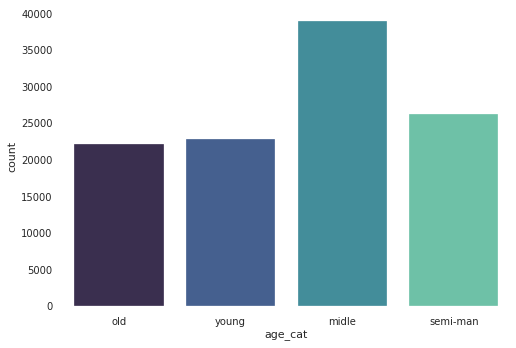

In [64]:
sns.countplot(df['age_cat'], palette='mako')

# decline_app_cnt

<AxesSubplot:xlabel='decline_app_cnt', ylabel='proportion'>

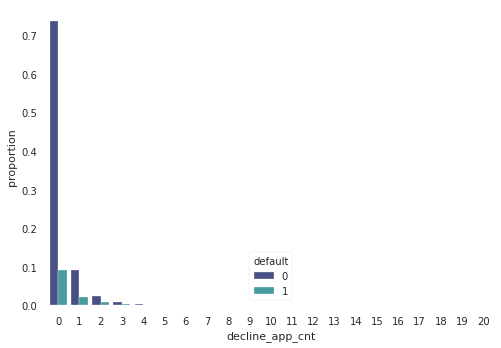

In [65]:
sns.barplot(x='decline_app_cnt', y='proportion', hue='default',  data=train[[
    'decline_app_cnt', 'default']].value_counts(normalize=True).rename('proportion').reset_index(), palette='mako')

#### Разделим на группы:
1. 0
2. 1
3. более или равно 2


   


In [66]:
df['decline_cat'] = df['decline_app_cnt'].apply(lambda x: 2 if x >= 2 else x)

In [67]:
df = df.drop('decline_app_cnt', axis=1)

# bki_request_cnt

<AxesSubplot:xlabel='bki_request_cnt', ylabel='proportion'>

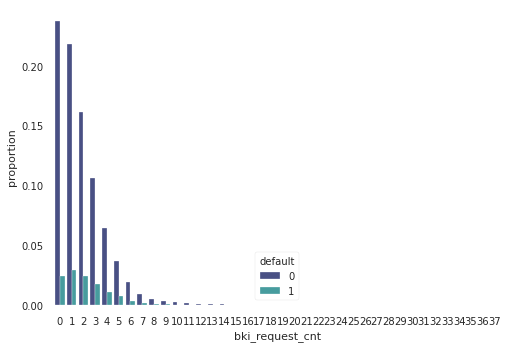

In [68]:
sns.barplot(x='bki_request_cnt', y='proportion', hue='default',  data=train[[
    'bki_request_cnt', 'default']].value_counts(normalize=True).rename('proportion').reset_index(), palette='mako')

#### Разделим на группы:
1. 0
2. 1
3. 2
4. 3
5. более или равно 4

   


In [69]:
df['bki_request_cat'] = df['bki_request_cnt'].apply(
    lambda x: 4 if x >= 4 else x)

In [70]:
df = df.drop('bki_request_cnt', axis=1)

# home_address & work_address

In [71]:
data = df[['work_address', 'home_address']].values
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data)
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df['pca_address'] = pca_data

In [72]:
df = df.drop(['home_address', 'work_address'], axis=1)

# app_date

In [73]:
df['app_date'] = pd.to_datetime(
    df['app_date'])  # Преобразуем в datetime

df['days_beetwen'] = df['app_date'].apply(
    lambda x: (get_days_beetwen(x)
               ))  # Кол- во дней между подачей заявки и сегодняшним числом
df['month'] = df['app_date'].apply(lambda x: (month(x)))
df = df.drop('app_date', axis=1)  # Удалим столбец app_date

# has_no_guarantor

In [74]:
df['has_no_guarantor'] = 0
df['has_no_guarantor'] = df[['education', 'has_no_guarantor']].apply(
    lambda x: has_no_garant(*x), axis=1)

In [75]:
df

,education,sex,good_work,score_bki,region_rating,income,sna,first_time,foreign_passport,default,test,car_comb,age_cat,decline_cat,bki_request_cat,pca_address,days_beetwen,month,has_no_guarantor
0,SCH,M,0,-2.008753,50,18000,4,1,N,0.0,0,2,old,0,1,-1.282573,2634,2,0
1,SCH,F,0,-1.532276,50,19000,4,1,N,0.0,0,0,old,0,3,1.086059,2595,3,0
2,SCH,M,0,-1.408142,80,30000,1,4,Y,0.0,0,1,young,2,1,-1.282573,2634,2,0
3,SCH,F,0,-2.057471,50,10000,1,3,N,0.0,0,0,old,0,2,1.086059,2643,1,0
4,GRD,M,1,-1.244723,60,30000,1,4,Y,0.0,0,0,midle,0,1,1.086059,2558,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,SCH,F,0,-1.744976,50,15000,4,1,N,NaN,1,0,midle,1,3,1.086059,2576,3,0
36345,GRD,F,0,-2.293781,60,200000,1,4,N,NaN,1,2,old,0,3,-1.282573,2551,4,0
36346,GRD,M,0,-0.940752,50,60000,4,2,N,NaN,1,0,semi-man,2,1,-1.282573,2577,3,0
36347,UGR,F,0,-1.242392,80,30000,1,1,N,NaN,1,0,young,1,2,1.086059,2659,1,0


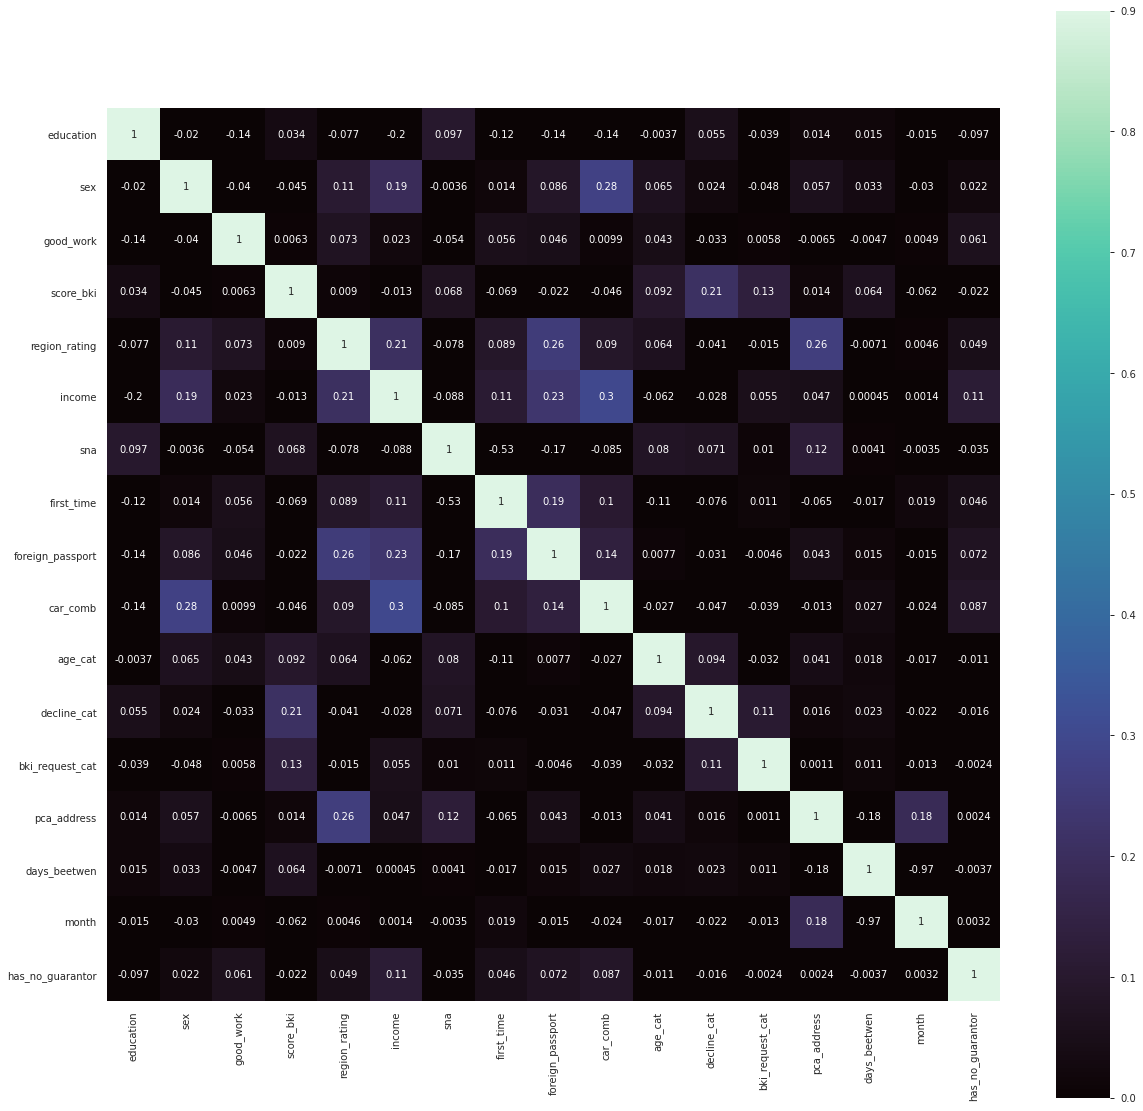

In [154]:
corr_matrix(df[df['test']==0].drop(['default', 'test'], axis=1),
            det=False, pltx=20, plty=20)

# ENCODING

In [76]:
# Для того, чтобы избежать inf значений после логарифмирования
df['pca_address'] = df['pca_address'] + 5

<AxesSubplot:>

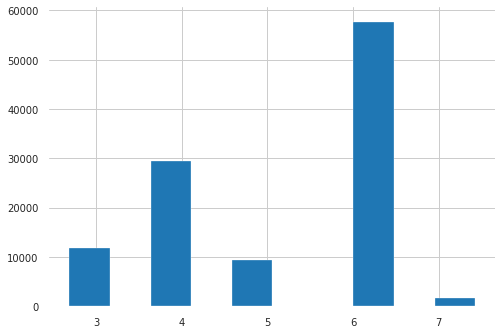

In [77]:
df['pca_address'].hist()

In [78]:
# Lable Encoding для категориальных признаков строкового типа
to_encode_cat = ['education', 'age_cat']
for i in to_encode_cat:
    pre_processing(i, df)

In [79]:
# Lable Encoding для бинарных признаков строкового типа
to_encode_bin = ['sex', 'foreign_passport', 'good_work', 'has_no_guarantor']
for i in to_encode_bin:
    pre_processing(i, df)

In [80]:
df

,education,sex,good_work,score_bki,region_rating,income,sna,first_time,foreign_passport,default,test,car_comb,age_cat,decline_cat,bki_request_cat,pca_address,days_beetwen,month,has_no_guarantor
0,3,1,0,-2.008753,50,18000,4,1,0,0.0,0,2,1,0,1,3.717427,2634,2,0
1,3,0,0,-1.532276,50,19000,4,1,0,0.0,0,0,1,0,3,6.086059,2595,3,0
2,3,1,0,-1.408142,80,30000,1,4,1,0.0,0,1,3,2,1,3.717427,2634,2,0
3,3,0,0,-2.057471,50,10000,1,3,0,0.0,0,0,1,0,2,6.086059,2643,1,0
4,1,1,1,-1.244723,60,30000,1,4,1,0.0,0,0,0,0,1,6.086059,2558,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,3,0,0,-1.744976,50,15000,4,1,0,NaN,1,0,0,1,3,6.086059,2576,3,0
36345,1,0,0,-2.293781,60,200000,1,4,0,NaN,1,2,1,0,3,3.717427,2551,4,0
36346,1,1,0,-0.940752,50,60000,4,2,0,NaN,1,0,2,2,1,3.717427,2577,3,0
36347,4,0,0,-1.242392,80,30000,1,1,0,NaN,1,0,3,1,2,6.086059,2659,1,0


In [81]:
# encoder = Preprocessing(df)
# cols_to_hot = ['education','region_rating','sna','first_time','car_comb','age_cat','decline_cat','bki_request_cat', 'month']
# for col in cols_to_hot:
#     df = encoder.hot_enc(col)

In [82]:
encoder_train = Preprocessing(df[df['test'] == 0])
cols_to_hot = ['education', 'region_rating', 'sna', 'first_time',
               'car_comb', 'age_cat', 'decline_cat', 'bki_request_cat', 'month']
for col in cols_to_hot:
    df_train_hotted = encoder_train.hot_enc(col)

In [83]:
df_train_hotted[:5]

,sex,good_work,score_bki,income,foreign_passport,default,test,pca_address,days_beetwen,has_no_guarantor,...,hot_encode_2,hot_encode_0,hot_encode_1,hot_encode_2,hot_encode_3,hot_encode_4,hot_encode_1,hot_encode_2,hot_encode_3,hot_encode_4
0,1,0,-2.008753,18000,0,0.0,0,3.717427,2634,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,0,-1.532276,19000,0,0.0,0,6.086059,2595,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,0,-1.408142,30000,1,0.0,0,3.717427,2634,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,0,-2.057471,10000,0,0.0,0,6.086059,2643,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,1,-1.244723,30000,1,0.0,0,6.086059,2558,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [84]:
encoder_test = Preprocessing(df[df['test'] == 1])
cols_to_hot = ['education', 'region_rating', 'sna', 'first_time',
               'car_comb', 'age_cat', 'decline_cat', 'bki_request_cat', 'month']
for col in cols_to_hot:
    df_test_hotted = encoder_test.hot_enc(col)

In [85]:
df_test_hotted[:5]

,sex,good_work,score_bki,income,foreign_passport,default,test,pca_address,days_beetwen,has_no_guarantor,...,hot_encode_2,hot_encode_0,hot_encode_1,hot_encode_2,hot_encode_3,hot_encode_4,hot_encode_1,hot_encode_2,hot_encode_3,hot_encode_4
0,1,0,-2.271884,50000,0,NaN,1,3.717427,2585,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0,0,-1.504999,5000,0,NaN,1,3.717427,2642,0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,0,-1.691339,30000,1,NaN,1,3.717427,2584,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,0,-2.374182,17000,0,NaN,1,3.717427,2632,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0,-2.487502,120000,0,NaN,1,6.086059,2631,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [86]:
df_train_hotted['pca_address'] = df_train_hotted['pca_address'] + 5 #Для избежания inf значений после логарифмирования
df_test_hotted['pca_address'] = df_test_hotted['pca_address'] + 5

In [87]:
'''ЛОГАРИФМИРОВАНИЕ'''
to_log = ['income', 'days_beetwen', 'pca_address']
for col in to_log:
    # Логарифмируем числовые данные в ранее разделенных датасетах
    df_train_hotted[col] = np.log(df_train_hotted[col])
for col in to_log:
    # Логарифмируем числовые данные в ранее разделенных датасетах
    df_test_hotted[col] = np.log(df_test_hotted[col])

In [88]:
df_test_hotted

,sex,good_work,score_bki,income,foreign_passport,default,test,pca_address,days_beetwen,has_no_guarantor,...,hot_encode_2,hot_encode_0,hot_encode_1,hot_encode_2,hot_encode_3,hot_encode_4,hot_encode_1,hot_encode_2,hot_encode_3,hot_encode_4
0,1,0,-2.271884,10.819778,0,NaN,1,2.165324,7.857481,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0,0,-1.504999,8.517193,0,NaN,1,2.165324,7.879291,0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,0,-1.691339,10.308953,1,NaN,1,2.165324,7.857094,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,0,-2.374182,9.740969,0,NaN,1,2.165324,7.875499,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0,-2.487502,11.695247,0,NaN,1,2.405688,7.875119,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,0,0,-1.744976,9.615805,0,NaN,1,2.405688,7.853993,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
36345,0,0,-2.293781,12.206073,0,NaN,1,2.165324,7.844241,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
36346,1,0,-0.940752,11.002100,0,NaN,1,2.165324,7.854381,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
36347,0,0,-1.242392,10.308953,0,NaN,1,2.405688,7.885705,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [89]:
to_scal = ['income', 'days_beetwen', 'pca_address']
scaler_num = RobustScaler()
df_train_scaled = scaler_num.fit_transform(df_train_hotted[to_scal].values)  #Скалируем числовые признаки в трейне
df_test_scaled = scaler_num.transform(df_test_hotted[to_scal].values) #Скалируем числовые признаки в тесте

# Удаляем отскалированные признаки из датасета
df_train_hotted = df_train_hotted.drop(to_scal, axis=1)
df_test_hotted = df_test_hotted.drop(to_scal, axis=1)

In [90]:
num = to_scal

# Модели
### Лог регрессия

In [91]:
X = np.hstack([df_train_scaled, df_train_hotted.drop(
    ['default', 'test'], axis=1).values])
y = df_train_hotted[['default']]
X_valid = np.hstack([df_test_scaled, df_test_hotted.drop(
    ['default', 'test'], axis=1).values])
print('Размерность X:{},\nРазмерность y: {},\nРазмерность валидационной выборки: {}'.format(
    X.shape, y.shape, X_valid.shape))

Размерность X:(73799, 47),
Размерность y: (73799, 1),
Размерность валидационной выборки: (36349, 47)


In [92]:
lr = LogisticRegression()

In [93]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=RANDOM_SEED)

In [94]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:, 1]
cf_matrix = confusion_matrix(y_test, y_pred)

In [95]:
# Создаем таблицу, где будем вести учет результатов
df_report = pd.DataFrame(columns={'ROC-AUG'}, data=[0])

df_report['ROC-AUG'] = roc_auc_score(y_test, y_pred_proba)
df_report['PR-AUC'] = precision_score(y_test, y_pred)
df_report['F1'] = f1_score(y_test, y_pred)
df_report['precision_0'] = precision_score(y_test, y_pred, pos_label=0)
df_report['recall_0'] = recall_score(y_test, y_pred, pos_label=0)
df_report['precision_1'] = precision_score(y_test, y_pred, pos_label=1)
df_report['recall_1'] = recall_score(y_test, y_pred, pos_label=1)

df_report.index = ['LogisticRegression']

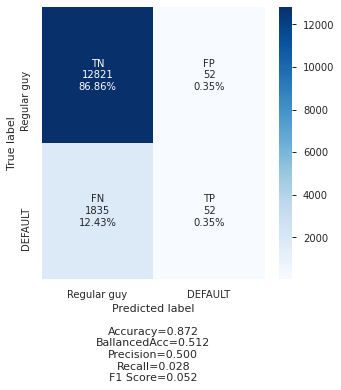

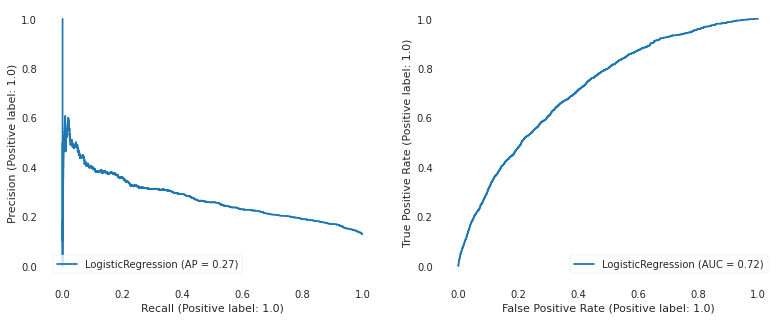

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     12873
         1.0       0.50      0.03      0.05      1887

    accuracy                           0.87     14760
   macro avg       0.69      0.51      0.49     14760
weighted avg       0.83      0.87      0.82     14760



,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.720061,0.5,0.052235,0.874795,0.995961,0.5,0.027557


In [96]:
categories = ['Regular guy', 'DEFAULT']
make_confusion_matrix(cf_matrix, categories=categories, sum_stats=True)
make_roc_auc(lr, X_test, y_test)
print(classification_report(y_test, y_pred))
df_report

#### **PR-REC AUC близок к 0.5, f1=0.056, что говорит о том, что алгоритм пока не способен как-либо различать классы, больше всего он присваивает объектам класс 0, попробуем подобрать наилучшие параметры, а также сделаем стратификацию, которая часто применяется при дисбалансе классов**

# Лог регрессия с стратификацией

In [97]:
# Grid Search
lr_skf = LogisticRegression(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=6, random_state=RANDOM_SEED)

param = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2']}

# refit - по умолчанию, в предикте уже используем лучшую модель
clf_model = GridSearchCV(
    lr_skf, param, scoring='roc_auc', refit=True, cv=skf)
clf_model.fit(X_train, y_train)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_model.best_score_, clf_model.best_params_))

Best roc_auc: 0.7404, with best C: {'C': 2.223, 'penalty': 'l2'}


In [98]:
y_pred_proba = clf_model.predict_proba(X_test)[:, 1]
y_pred = clf_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
df_report = get_scores(df_report, clf_model, X_test,
                       y_test, 'LogisticRegression_skf')

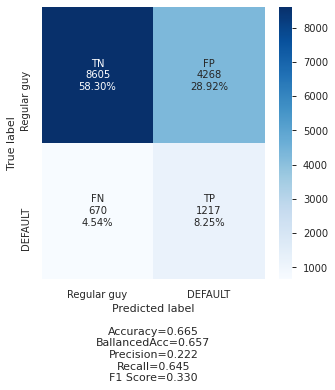

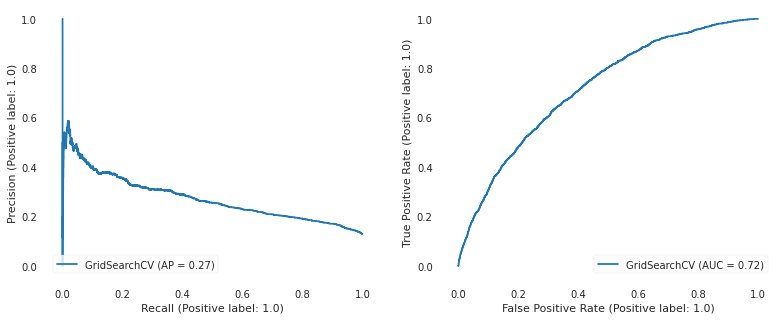

              precision    recall  f1-score   support

         0.0       0.93      0.67      0.78     12873
         1.0       0.22      0.64      0.33      1887

    accuracy                           0.67     14760
   macro avg       0.57      0.66      0.55     14760
weighted avg       0.84      0.67      0.72     14760



,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.720061,0.500000,0.052235,0.874795,0.995961,0.500000,0.027557
LogisticRegression_skf,0.719863,0.221878,0.330168,0.927763,0.668453,0.221878,0.644939


In [99]:
make_confusion_matrix(cf_matrix, categories=categories, sum_stats=True)
make_roc_auc(clf_model, X_test, y_test)
print(classification_report(y_test, y_pred))
df_report

**Видим, что в классе 0 поднялась точность и упала полнота, в кассе 1 упала точность и заметно поднялась полнота. В целом подросла f1, но большой разницы при балансировке классов не видно с учетом поиска лучших параметров и статифицированной выборки для обучения.**

**Добавим объектов недостоющего класса**

# Oversampling

In [100]:
oversample = RandomOverSampler(sampling_strategy=1)
X_over, y_over = oversample.fit_resample(X, y)

In [101]:
X_train_ov, X_test_ov, y_train_ov, y_test_ov = train_test_split(X_over,
                                                    y_over,
                                                    test_size=.2,
                                                    random_state=RANDOM_SEED)

In [102]:
# Grid Search
model_skf_over = LogisticRegression()
skf = StratifiedShuffleSplit(n_splits=5, random_state=RANDOM_SEED)

param = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2']}

# refit - по умолчанию, в предикте уже используем лучшую модель
clf_model_over = GridSearchCV(
    model_skf_over, param, scoring='roc_auc', refit=True, cv=skf, verbose=1)
clf_model_over.fit(X_train_ov, y_train_ov)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_model_over.best_score_, clf_model_over.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best roc_auc: 0.7316, with best C: {'C': 3.334, 'penalty': 'l2'}


In [103]:
y_pred_proba = clf_model_over.predict_proba(X_test_ov)[:, 1]
y_pred = clf_model_over.predict(X_test_ov)
cf_matrix = confusion_matrix(y_test_ov, y_pred)
df_report = get_scores(df_report, clf_model_over, X_test_ov,
                       y_test_ov, 'LogisticRegression_skf_over')

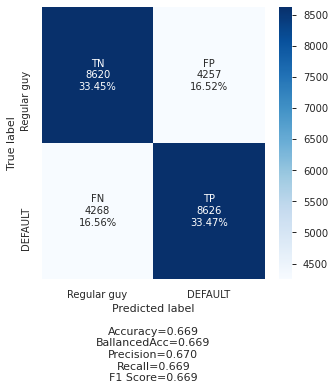

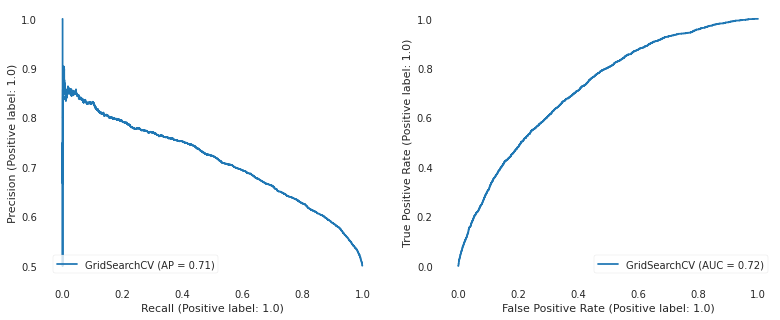

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67     12877
         1.0       0.67      0.67      0.67     12894

    accuracy                           0.67     25771
   macro avg       0.67      0.67      0.67     25771
weighted avg       0.67      0.67      0.67     25771



,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.720061,0.500000,0.052235,0.874795,0.995961,0.500000,0.027557
LogisticRegression_skf,0.719863,0.221878,0.330168,0.927763,0.668453,0.221878,0.644939
LogisticRegression_skf_over,0.733236,0.669565,0.669279,0.668839,0.669411,0.669565,0.668993


In [104]:
make_confusion_matrix(cf_matrix, categories=categories, sum_stats=True)
make_roc_auc(clf_model_over, X_test_ov, y_test_ov)
print(classification_report(y_test_ov, y_pred))
df_report

После использоания oversampling методики на всей тренировочной выборке X, y без параметра балансировки, значения оценок сбалансировались.
(oversampling на X_train не показал выдающихся результатов из-за недостатка данных)
Заметим, что достаточно хорошо работает  встроенный параметр class_weight='balanced'.



# Undersampling

In [105]:
undersample = RandomUnderSampler(sampling_strategy=1.0)
X_under, y_under = undersample.fit_resample(X, y)



In [106]:
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(X_under,
                                                    y_under,
                                                    test_size=.2,
                                                    random_state=RANDOM_SEED)

In [107]:
# Grid Search
model_skf_under = LogisticRegression()
skf = StratifiedShuffleSplit(n_splits=5, random_state=RANDOM_SEED)

param = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2']}

# refit - по умолчанию, в предикте уже используем лучшую модель
clf_model_under = GridSearchCV(
    model_skf_under, param, scoring='roc_auc', refit=True, cv=skf, verbose=1)
clf_model_under.fit(X_train_un, y_train_un)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_model_under.best_score_, clf_model_under.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best roc_auc: 0.7284, with best C: {'C': 1.1119999999999999, 'penalty': 'l2'}


In [108]:
y_pred_proba = clf_model_under.predict_proba(X_test_un)[:, 1]
y_pred = clf_model_under.predict(X_test_un)
cf_matrix = confusion_matrix(y_test_un, y_pred)
df_report = get_scores(df_report, clf_model_under, X_test_un,
                       y_test_un, 'LogisticRegression_skf_under')

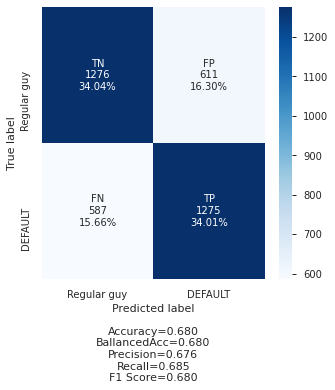

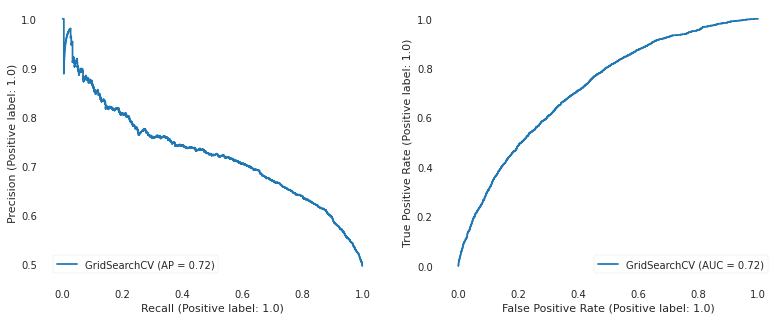

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      1887
         1.0       0.68      0.68      0.68      1862

    accuracy                           0.68      3749
   macro avg       0.68      0.68      0.68      3749
weighted avg       0.68      0.68      0.68      3749



,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.720061,0.500000,0.052235,0.874795,0.995961,0.500000,0.027557
LogisticRegression_skf,0.719863,0.221878,0.330168,0.927763,0.668453,0.221878,0.644939
LogisticRegression_skf_over,0.733236,0.669565,0.669279,0.668839,0.669411,0.669565,0.668993
LogisticRegression_skf_under,0.744294,0.676034,0.680363,0.684917,0.676206,0.676034,0.684748


In [109]:
make_confusion_matrix(cf_matrix, categories=categories, sum_stats=True)
make_roc_auc(clf_model_under, X_test_un, y_test_un)
print(classification_report(y_test_un, y_pred))
df_report

####  Видим, что Undersampling дает результаты близкие Oversampling-у


In [110]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [111]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

In [112]:
df_report = get_scores(df_report, rf, X_test, y_test, 'RandomForestClassifier')

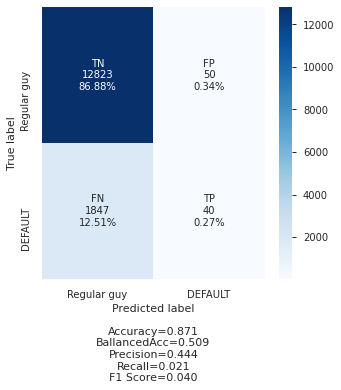

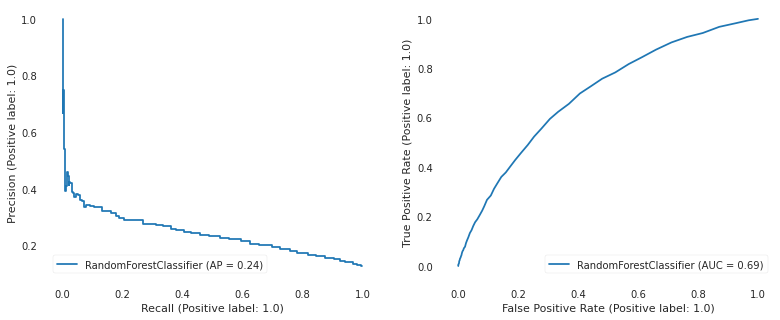

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     12873
         1.0       0.44      0.02      0.04      1887

    accuracy                           0.87     14760
   macro avg       0.66      0.51      0.49     14760
weighted avg       0.82      0.87      0.82     14760



,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.720061,0.500000,0.052235,0.874795,0.995961,0.500000,0.027557
LogisticRegression_skf,0.719863,0.221878,0.330168,0.927763,0.668453,0.221878,0.644939
LogisticRegression_skf_over,0.733236,0.669565,0.669279,0.668839,0.669411,0.669565,0.668993
LogisticRegression_skf_under,0.744294,0.676034,0.680363,0.684917,0.676206,0.676034,0.684748
RandomForestClassifier,0.694140,0.444444,0.040465,0.874097,0.996116,0.444444,0.021198


In [113]:
make_confusion_matrix(cf_matrix, categories=categories, sum_stats=True)
make_roc_auc(rf, X_test, y_test)
print(classification_report(y_test, y_pred))
df_report

#### Random Forest показал самый худший результат.
**Попробуем  использвать стратификацию и параметр балансировки**

## Random Forest с стратификацией

In [114]:
# Grid Search
rf_skf = RandomForestClassifier(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'bootstrap': [True],
         'max_depth': [10, 30],
         'n_estimators': [600, 1000]}


clf_rf = GridSearchCV(
    rf_skf, param, scoring='roc_auc', refit=True, cv=skf, verbose=3, n_jobs=-1)
clf_rf.fit(X_train, y_train)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_rf.best_score_, clf_rf.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best roc_auc: 0.7338, with best C: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 1000}


In [115]:
y_pred_proba = clf_rf.predict_proba(X_test)[:, 1]
y_pred = clf_rf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

In [116]:
df_report = get_scores(df_report, clf_rf, X_test, y_test,
                       'RandomForestClassifier_skf')

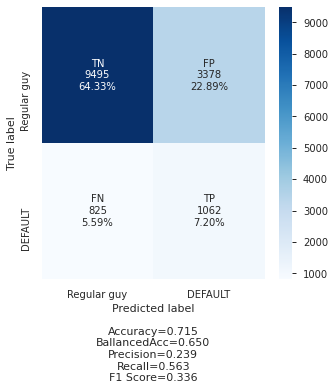

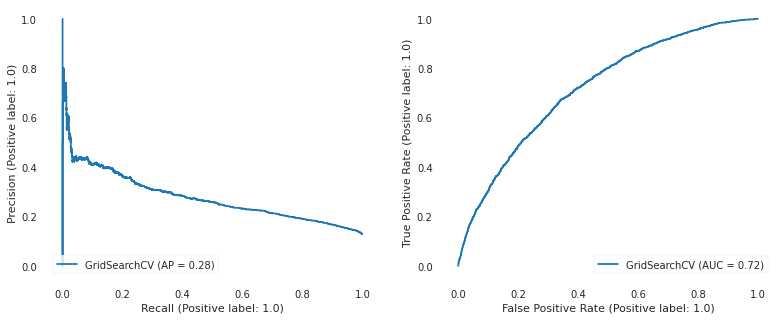

              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82     12873
         1.0       0.24      0.56      0.34      1887

    accuracy                           0.72     14760
   macro avg       0.58      0.65      0.58     14760
weighted avg       0.83      0.72      0.76     14760



,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.720061,0.500000,0.052235,0.874795,0.995961,0.500000,0.027557
LogisticRegression_skf,0.719863,0.221878,0.330168,0.927763,0.668453,0.221878,0.644939
LogisticRegression_skf_over,0.733236,0.669565,0.669279,0.668839,0.669411,0.669565,0.668993
LogisticRegression_skf_under,0.744294,0.676034,0.680363,0.684917,0.676206,0.676034,0.684748
RandomForestClassifier,0.694140,0.444444,0.040465,0.874097,0.996116,0.444444,0.021198
RandomForestClassifier_skf,0.720725,0.239189,0.335704,0.920058,0.737590,0.239189,0.562798


In [117]:
make_confusion_matrix(cf_matrix, categories=categories, sum_stats=True)
make_roc_auc(clf_rf, X_test, y_test)
print(classification_report(y_test, y_pred))
df_report

### Случайный лес с стратификацией показал результат не сильно выше логистической регрессии с стратификацией. Но мы используем лучшие параметры,которые выяснили в процессе

# Lightgbm

## Модель является разновидностью градиентного бустинга. Учится на ошибках построенных последовательностью алгоритмов.

In [118]:
from lightgbm import LGBMModel, LGBMClassifier

In [119]:
df[df['test'] == 1].drop(['default', 'test'], axis=1)

,education,sex,good_work,score_bki,region_rating,income,sna,first_time,foreign_passport,car_comb,age_cat,decline_cat,bki_request_cat,pca_address,days_beetwen,month,has_no_guarantor
0,1,1,0,-2.271884,50,50000,1,4,0,2,2,0,3,3.717427,2585,3,0
1,3,0,0,-1.504999,50,5000,4,3,0,0,0,2,2,3.717427,2642,1,0
2,4,1,0,-1.691339,50,30000,1,3,1,2,0,0,1,3.717427,2584,3,0
3,3,1,0,-2.374182,40,17000,1,3,0,0,1,0,1,3.717427,2632,2,0
4,1,0,0,-2.487502,80,120000,1,3,0,0,0,0,0,6.086059,2631,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,3,0,0,-1.744976,50,15000,4,1,0,0,0,1,3,6.086059,2576,3,0
36345,1,0,0,-2.293781,60,200000,1,4,0,2,1,0,3,3.717427,2551,4,0
36346,1,1,0,-0.940752,50,60000,4,2,0,0,2,2,1,3.717427,2577,3,0
36347,4,0,0,-1.242392,80,30000,1,1,0,0,3,1,2,6.086059,2659,1,0


In [122]:
df

,education,sex,good_work,score_bki,region_rating,income,sna,first_time,foreign_passport,default,test,car_comb,age_cat,decline_cat,bki_request_cat,pca_address,days_beetwen,month,has_no_guarantor
0,3,1,0,-2.008753,50,18000,4,1,0,0.0,0,2,1,0,1,3.717427,2634,2,0
1,3,0,0,-1.532276,50,19000,4,1,0,0.0,0,0,1,0,3,6.086059,2595,3,0
2,3,1,0,-1.408142,80,30000,1,4,1,0.0,0,1,3,2,1,3.717427,2634,2,0
3,3,0,0,-2.057471,50,10000,1,3,0,0.0,0,0,1,0,2,6.086059,2643,1,0
4,1,1,1,-1.244723,60,30000,1,4,1,0.0,0,0,0,0,1,6.086059,2558,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,3,0,0,-1.744976,50,15000,4,1,0,NaN,1,0,0,1,3,6.086059,2576,3,0
36345,1,0,0,-2.293781,60,200000,1,4,0,NaN,1,2,1,0,3,3.717427,2551,4,0
36346,1,1,0,-0.940752,50,60000,4,2,0,NaN,1,0,2,2,1,3.717427,2577,3,0
36347,4,0,0,-1.242392,80,30000,1,1,0,NaN,1,0,3,1,2,6.086059,2659,1,0


In [123]:
cols = []

In [124]:
for i in df.columns:
    cols.append('name_'+i)

In [125]:
df_ = pd.DataFrame(columns=cols, data=df.values)

In [126]:
X_ = df_[df_['name_test'] == 0].drop(['name_default', 'name_test'], axis=1)
y_ = df_[df_['name_test'] == 0]['name_default']
X_val = df_[df_['name_test'] == 1].drop(['name_default', 'name_test'], axis=1)

In [127]:
for c in X_.columns:
    col_type = X_[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_[c] = X_[c].astype('category')

In [128]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X_, y_, test_size=0.2, random_state=RANDOM_SEED)

In [129]:
lgb = LGBMClassifier(learning_rate=0.005, n_estimators=600, num_leaves=50)
lgb.fit(X_train_, y_train_, categorical_feature='auto')

df_report = get_scores(df_report, lgb, X_test_, y_test_, 'LGBMClassifier')

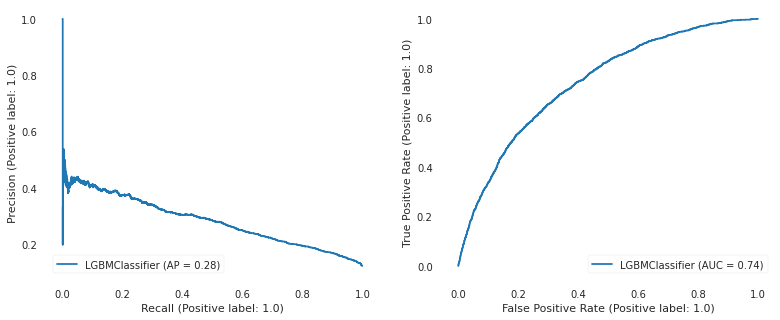

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

plot_precision_recall_curve(lgb, X_test_, y_test_, ax=ax1)
plot_roc_curve(lgb, X_test_, y_test_, ax=ax2)

In [132]:
y_pred_proba_lgb = lgb.predict_proba(X_test_)[:, 1]
y_pred_lgb = lgb.predict(X_test_)
cf_matrix = confusion_matrix(y_test_, y_pred_lgb)

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93     12933
         1.0       0.47      0.00      0.01      1827

    accuracy                           0.88     14760
   macro avg       0.67      0.50      0.47     14760
weighted avg       0.83      0.88      0.82     14760



,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.720061,0.500000,0.052235,0.874795,0.995961,0.500000,0.027557
LogisticRegression_skf,0.719863,0.221878,0.330168,0.927763,0.668453,0.221878,0.644939
LogisticRegression_skf_over,0.733236,0.669565,0.669279,0.668839,0.669411,0.669565,0.668993
LogisticRegression_skf_under,0.744294,0.676034,0.680363,0.684917,0.676206,0.676034,0.684748
RandomForestClassifier,0.694140,0.444444,0.040465,0.874097,0.996116,0.444444,0.021198
RandomForestClassifier_skf,0.720725,0.239189,0.335704,0.920058,0.737590,0.239189,0.562798
LGBMClassifier,0.742054,0.470588,0.008677,0.876619,0.999304,0.470588,0.004379


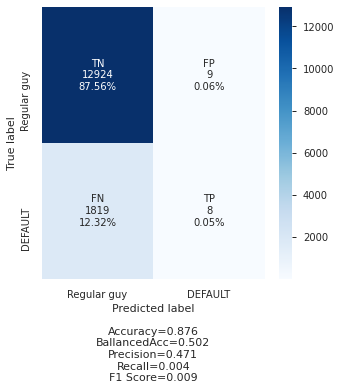

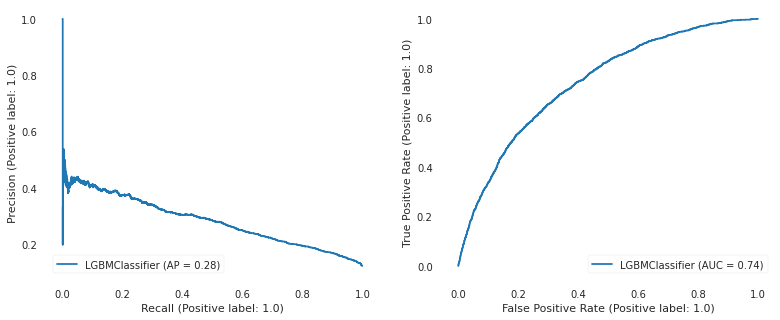

In [133]:
make_confusion_matrix(cf_matrix, categories=categories, sum_stats=True)
print(classification_report(y_test_, y_pred_lgb))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
plot_precision_recall_curve(lgb, X_test_, y_test_, ax=ax1)
plot_roc_curve(lgb, X_test_, y_test_, ax=ax2)
df_report

 Модель на основе бустинга хорошо ищет недефолтных, но плохо дефолтных. Так же плохо ищет ошибочно дефолтных и чуть лучше ошибочно недефолтных. 
#### Попробуем с стратификацией

In [134]:
lgb_skf = LGBMClassifier(class_weight='balanced', categorical_feature=[0])
skf = StratifiedShuffleSplit(n_splits=5, random_state=RANDOM_SEED)

param = {'learning_rate': [0.005, 0.1],
         'num_leaves': [30, 50],
         'n_estimators': [500, 600]}

clf_lgb = GridSearchCV(lgb_skf, param, scoring='roc_auc',
                       cv=skf, verbose=3, n_jobs=-1)
clf_lgb.fit(X_train_, y_train_)

y_pred_lgb_clf = clf_lgb.predict(X_test_)
cf_matrix = confusion_matrix(y_test_, y_pred_lgb_clf)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_lgb.best_score_, clf_lgb.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best roc_auc: 0.7308, with best C: {'learning_rate': 0.005, 'n_estimators': 600, 'num_leaves': 50}


In [135]:
df_report = get_scores(df_report, clf_lgb, X_test_,
                       y_test_, 'LGBMClassifier_skf')

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93     12933
         1.0       0.47      0.00      0.01      1827

    accuracy                           0.88     14760
   macro avg       0.67      0.50      0.47     14760
weighted avg       0.83      0.88      0.82     14760



,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.720061,0.500000,0.052235,0.874795,0.995961,0.500000,0.027557
LogisticRegression_skf,0.719863,0.221878,0.330168,0.927763,0.668453,0.221878,0.644939
LogisticRegression_skf_over,0.733236,0.669565,0.669279,0.668839,0.669411,0.669565,0.668993
LogisticRegression_skf_under,0.744294,0.676034,0.680363,0.684917,0.676206,0.676034,0.684748
RandomForestClassifier,0.694140,0.444444,0.040465,0.874097,0.996116,0.444444,0.021198
RandomForestClassifier_skf,0.720725,0.239189,0.335704,0.920058,0.737590,0.239189,0.562798
LGBMClassifier,0.742054,0.470588,0.008677,0.876619,0.999304,0.470588,0.004379
LGBMClassifier_skf,0.741756,0.228061,0.342091,0.937817,0.672852,0.228061,0.684182


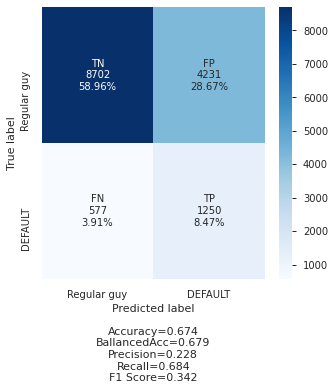

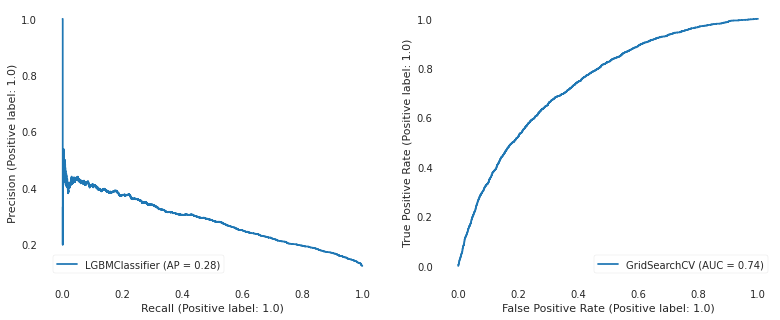

In [136]:
make_confusion_matrix(cf_matrix, categories=categories, sum_stats=True)
print(classification_report(y_test_, y_pred_lgb))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
plot_precision_recall_curve(lgb, X_test_, y_test_, ax=ax1)
plot_roc_curve(clf_lgb, X_test_, y_test_, ax=ax2)
df_report

# LGBCM с Oversamplinfg

In [137]:
oversample_ = RandomUnderSampler(sampling_strategy=1.0)
X_over_, y_over_ = oversample.fit_resample(X_, y_)


In [138]:
lgb_skf_over = LGBMClassifier(categorical_feature=[0])
skf = StratifiedShuffleSplit(n_splits=5, random_state=RANDOM_SEED)

param = {'learning_rate': [0.005, 0.1],
         'num_leaves': [30, 50],
         'n_estimators': [500, 600]}

clf_lgb_over = GridSearchCV(lgb_skf_over, param, scoring='roc_auc',
                       cv=skf, verbose=3, n_jobs=-1)
clf_lgb_over.fit(X_over_, y_over_)

y_pred_lgb_clf_over = clf_lgb.predict(X_test_)
cf_matrix = confusion_matrix(y_test_, y_pred_lgb_clf_over)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_lgb_over.best_score_, clf_lgb_over.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best roc_auc: 0.9209, with best C: {'learning_rate': 0.1, 'n_estimators': 600, 'num_leaves': 50}


In [139]:
df_report = get_scores(df_report, clf_lgb_over, X_test_,
                       y_test_, 'LGBMClassifier_skf_over')

              precision    recall  f1-score   support

         0.0       0.94      0.67      0.78     12933
         1.0       0.23      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760



,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.720061,0.500000,0.052235,0.874795,0.995961,0.500000,0.027557
LogisticRegression_skf,0.719863,0.221878,0.330168,0.927763,0.668453,0.221878,0.644939
LogisticRegression_skf_over,0.733236,0.669565,0.669279,0.668839,0.669411,0.669565,0.668993
LogisticRegression_skf_under,0.744294,0.676034,0.680363,0.684917,0.676206,0.676034,0.684748
RandomForestClassifier,0.694140,0.444444,0.040465,0.874097,0.996116,0.444444,0.021198
RandomForestClassifier_skf,0.720725,0.239189,0.335704,0.920058,0.737590,0.239189,0.562798
LGBMClassifier,0.742054,0.470588,0.008677,0.876619,0.999304,0.470588,0.004379
LGBMClassifier_skf,0.741756,0.228061,0.342091,0.937817,0.672852,0.228061,0.684182
LGBMClassifier_skf_over,0.950186,0.450647,0.603794,0.985885,0.842496,0.450647,0.914614


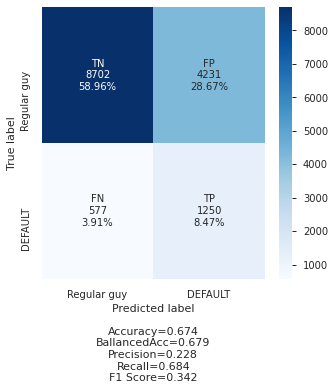

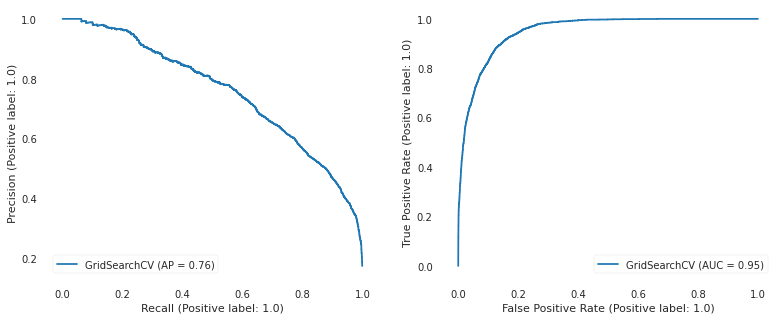

In [140]:
make_confusion_matrix(cf_matrix, categories=categories, sum_stats=True)
print(classification_report(y_test_, y_pred_lgb_clf_over))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
plot_precision_recall_curve(clf_lgb_over, X_test_, y_test_, ax=ax1)
plot_roc_curve(clf_lgb_over, X_test_, y_test_, ax=ax2)
df_report

Отработал лучше других

In [141]:
from sklearn.ensemble import VotingClassifier

# Стэкинг

#### Попробуем применить стекинг над разными моделями с помощью Soft voting (argmax суммы предсказанных вероятностей)

In [148]:
# lgbm_ = LGBMClassifier(learning_rate=0.005, n_estimators=600, num_leaves=70)
rf_ = RandomForestClassifier(bootstrap=True, max_depth=10, n_estimators=1000)
# lr_ = LogisticRegression(C=1.1119999999999999, penalty='l2')
clf_st = VotingClassifier(
    estimators=[('lr', clf_model_under), ('rf', rf_), ('lgb', clf_lgb_over)], voting='soft')
clf_st.fit(X_over_, y_over_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


VotingClassifier(estimators=[('lr',
                              GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=None,
            train_size=None),
                                           estimator=LogisticRegression(),
                                           param_grid={'C': array([1.000e-03, 1.112e+00, 2.223e+00, 3.334e+00, 4.445e+00, 5.556e+00,
       6.667e+00, 7.778e+00, 8.889e+00, 1.000e+01]),
                                                       'penalty': ['l1', 'l2']},
                                           scoring='roc_auc', verbose=1)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=1000)),
                             ('lgb',
                              GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=None,
            train_size=None),
                                           es

In [149]:
y_pred_clf_st = clf_st.predict(X_over_)
cf_matrix = confusion_matrix(y_over_, y_pred_clf_st)

In [150]:
df_report = get_scores(df_report, clf_st, X_over_, y_over_, 'Voting')

              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79     64427
         1.0       0.78      0.82      0.80     64427

    accuracy                           0.80    128854
   macro avg       0.80      0.80      0.80    128854
weighted avg       0.80      0.80      0.80    128854



,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.720061,0.500000,0.052235,0.874795,0.995961,0.500000,0.027557
LogisticRegression_skf,0.719863,0.221878,0.330168,0.927763,0.668453,0.221878,0.644939
LogisticRegression_skf_over,0.733236,0.669565,0.669279,0.668839,0.669411,0.669565,0.668993
LogisticRegression_skf_under,0.744294,0.676034,0.680363,0.684917,0.676206,0.676034,0.684748
RandomForestClassifier,0.694140,0.444444,0.040465,0.874097,0.996116,0.444444,0.021198
RandomForestClassifier_skf,0.720725,0.239189,0.335704,0.920058,0.737590,0.239189,0.562798
LGBMClassifier,0.742054,0.470588,0.008677,0.876619,0.999304,0.470588,0.004379
LGBMClassifier_skf,0.741756,0.228061,0.342091,0.937817,0.672852,0.228061,0.684182
LGBMClassifier_skf_over,0.950186,0.450647,0.603794,0.985885,0.842496,0.450647,0.914614
Voting,0.881466,0.783200,0.802139,0.812735,0.772456,0.783200,0.822016


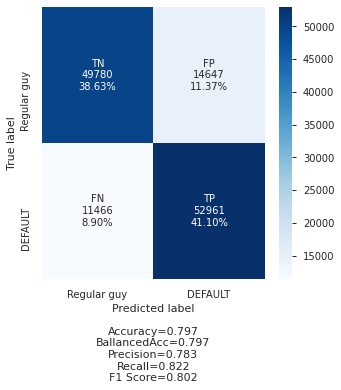

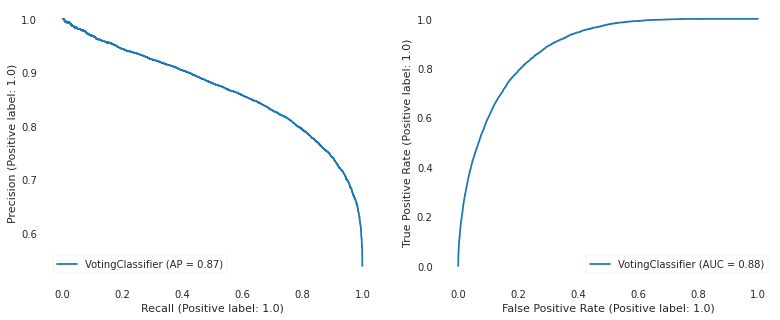

In [151]:
make_confusion_matrix(cf_matrix, categories=categories, sum_stats=True)
print(classification_report(y_over_, y_pred_clf_st))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
plot_precision_recall_curve(clf_st, X_over_, y_over_, ax=ax1)
plot_roc_curve(clf_st, X_over_, y_over_, ax=ax2)
df_report

In [152]:
id_test = test['client_id']

In [153]:
submission = pd.DataFrame({'client_id': id_test,
                           'default': clf_st.predict_proba(X_val)[:, 1]})
submission.to_csv('submission.csv', index=False)

submission

,client_id,default
0,74835,0.189630
1,17527,0.606999
2,75683,0.360658
3,26883,0.340785
4,28862,0.098623
...,...,...
36344,83775,0.786237
36345,106254,0.103431
36346,81852,0.672897
36347,1971,0.701531
